## **Exploratory Data Analysis (EDA)**

### **Importing Libraries**

In [9]:
import json
import logging
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import streamlit as st

from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from catboost import CatBoostRegressor

### **Problem statement and data collection**

In [10]:
esg_csv = "../data/raw/sp500_esg_ceo_info-filtered.csv"  
esg_df = pd.read_csv(esg_csv)

logging.getLogger("yfinance").setLevel(logging.ERROR)

print("Columns CSV ESG:", esg_df.columns)
print("Number of tickers in CSV:", esg_df["Ticker"].nunique())

Columns CSV ESG: Index(['Ticker', 'ESG Score', 'Governance Score', 'Environment Score',
       'Social Score', 'ESG Score Date', 'ESG Status', 'CEO Full Name',
       'CEO Gender', 'CEO Status', 'Year'],
      dtype='object')
Number of tickers in CSV: 426


In [11]:
tickers = esg_df["Ticker"].dropna().unique().tolist()[:400]

start_date = "2022-01-01"
end_date = "2023-12-31"

all_data = []


In [12]:
batch_size = 400
for i in range(0, len(tickers), batch_size):
    batch = tickers[i:i+batch_size]
    print(f"\nDonwloading batch {i//batch_size + 1} of {len(tickers)//batch_size + 1}...")
    
    try:
        df = yf.download(
            batch,
            start=start_date,
            end=end_date,
            progress=False,
            auto_adjust=False  # 
        )
        
        # Converting from multi-index columns to simple columns
        df = df.stack(level=1).reset_index()
        df.rename(columns={"level_1": "Ticker"}, inplace=True)
        
        all_data.append(df)
    except Exception as e:
        print(f"Error in batch {i//batch_size + 1}: {e}")



Donwloading batch 1 of 2...



8 Failed downloads:
['PEAK', 'MRO', 'HES', 'ANSS', 'DFS', 'PXD', 'FLT', 'JNPR']: YFTzMissingError('possibly delisted; no timezone found')
/tmp/ipykernel_56051/837766032.py:16: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack(level=1).reset_index()


In [13]:
# Combine all financial data
fin_df = pd.concat(all_data, ignore_index=True)

print(f"\nFinancial data: {fin_df.shape}")


Financial data: (196392, 8)


In [14]:
# Merge with ESG data (by ticker)
dataset_final = pd.merge(fin_df, esg_df, on="Ticker", how="inner")

In [15]:
# Create volatility features to obtain 2 potential targets (y) for our future predictive model


dataset_final["Daily_Return"] = dataset_final.groupby("Ticker")["Adj Close"].pct_change()
dataset_final["Daily_Volatility"] = (
    dataset_final.groupby("Ticker")["Daily_Return"]
    .rolling(5)
    .std()
    .reset_index(0, drop=True)
)

In [16]:
# Save final CSV
dataset_final.to_csv("dataset_final.csv", index=False)

print(f"\nDataset saved as 'dataset_final.csv'")
print("Final shape:", dataset_final.shape)
print("\nFirst rows:\n", dataset_final.head())

dataset_final.info()


Dataset saved as 'dataset_final.csv'
Final shape: (196392, 20)

First rows:
         Date Ticker   Adj Close       Close        High         Low  \
0 2022-01-03      A  152.625900  156.479996  159.440002  153.929993   
1 2022-01-03    AAL   18.750000   18.750000   19.180000   18.200001   
2 2022-01-03   AAPL  178.443115  182.009995  182.880005  177.710007   
3 2022-01-03   ABBV  117.621185  135.419998  135.699997  133.509995   
4 2022-01-03    ABT  129.569733  139.039993  139.830002  137.210007   

         Open       Volume  ESG Score  Governance Score  Environment Score  \
0  159.000000    1606300.0      15.24              6.26               0.34   
1   18.230000   42781000.0      29.10              5.26              11.53   
2  177.830002  104487900.0      16.68              9.18               0.65   
3  135.410004    6839800.0      27.84              9.95               1.12   
4  139.429993    6688100.0      24.98              8.36               3.03   

   Social Score ESG Score 

### **Exploration and data cleaning**

In [8]:
dataset_final.head()

Date Ticker   Adj Close       Close        High         Low  \
0 2022-01-03      A  152.625885  156.479996  159.440002  153.929993   
1 2022-01-03    AAL   18.750000   18.750000   19.180000   18.200001   
2 2022-01-03   AAPL  178.443130  182.009995  182.880005  177.710007   
3 2022-01-03   ABBV  117.621170  135.419998  135.699997  133.509995   
4 2022-01-03    ABT  129.569748  139.039993  139.830002  137.210007   

         Open       Volume  ESG Score  Governance Score  Environment Score  \
0  159.000000    1606300.0      15.24              6.26               0.34   
1   18.230000   42781000.0      29.10              5.26              11.53   
2  177.830002  104487900.0      16.68              9.18               0.65   
3  135.410004    6839800.0      27.84              9.95               1.12   
4  139.429993    6688100.0      24.98              8.36               3.03   

   Social Score ESG Score Date ESG Status            CEO Full Name CEO Gender  \
0          8.65     01/01/2023    success  Mr. Michael R. McMullen       male   
1         12.31     01/01/2023    success   Mr. Robert D. Isom Jr.       male   
2          6.86     01/08/2022    success      Mr. Timothy D. Cook       male   
3         16.77     01/08/2022    success  Mr. Richard A. Gonzalez       male   
4         13.59     01/08/2022    success       Mr. Robert B. Ford       male   

  CEO Status  Year  Daily_Return  Daily_Volatility  
0    success    23           NaN               NaN  
1    success    23           NaN               NaN  
2    success    22           NaN               NaN  
3    success    22           NaN               NaN  
4    success    22           NaN               NaN

In [9]:
dataset_final.shape

(196392, 20)

In [10]:
dataset_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196392 entries, 0 to 196391
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               196392 non-null  datetime64[ns]
 1   Ticker             196392 non-null  object        
 2   Adj Close          196392 non-null  float64       
 3   Close              196392 non-null  float64       
 4   High               196392 non-null  float64       
 5   Low                196392 non-null  float64       
 6   Open               196392 non-null  float64       
 7   Volume             196392 non-null  float64       
 8   ESG Score          196392 non-null  float64       
 9   Governance Score   196392 non-null  float64       
 10  Environment Score  196392 non-null  float64       
 11  Social Score       196392 non-null  float64       
 12  ESG Score Date     196392 non-null  object        
 13  ESG Status         196392 non-null  object  

### **Eliminate duplicates**


In [17]:
dataset_final.drop_duplicates()

Date Ticker   Adj Close       Close        High         Low  \
0      2022-01-03      A  152.625900  156.479996  159.440002  153.929993   
1      2022-01-03    AAL   18.750000   18.750000   19.180000   18.200001   
2      2022-01-03   AAPL  178.443115  182.009995  182.880005  177.710007   
3      2022-01-03   ABBV  117.621185  135.419998  135.699997  133.509995   
4      2022-01-03    ABT  129.569733  139.039993  139.830002  137.210007   
...           ...    ...         ...         ...         ...         ...   
196387 2023-12-29   VRSN  204.808975  205.960007  207.119995  204.500000   
196388 2023-12-29    VTR   47.474953   49.840000   50.430000   49.830002   
196389 2023-12-29    WRB   45.528275   47.146667   47.240002   46.740002   
196390 2023-12-29    XOM   94.075005   99.980003  100.589996   99.620003   
196391 2023-12-29   XRAY   33.988079   35.590000   35.680000   35.369999   

              Open       Volume  ESG Score  Governance Score  \
0       159.000000    1606300.0      15.24              6.26   
1        18.230000   42781000.0      29.10              5.26   
2       177.830002  104487900.0      16.68              9.18   
3       135.410004    6839800.0      27.84              9.95   
4       139.429993    6688100.0      24.98              8.36   
...            ...          ...        ...               ...   
196387  206.660004     450200.0      21.44              5.93   
196388   50.099998    1748300.0      12.75              5.73   
196389   47.026669    1179000.0      21.97             12.04   
196390  100.370003   17746400.0      36.47              8.10   
196391   35.380001    1330600.0      15.78              6.71   

        Environment Score  Social Score ESG Score Date ESG Status  \
0                    0.34          8.65     01/01/2023    success   
1                   11.53         12.31     01/01/2023    success   
2                    0.65          6.86     01/08/2022    success   
3                    1.12         16.77     01/08/2022    success   
4                    3.03         13.59     01/08/2022    success   
...                   ...           ...            ...        ...   
196387               4.74         10.77     01/01/2023    success   
196388               2.75          4.28     01/01/2023    success   
196389               1.97          7.95     01/01/2023    success   
196390              18.55          9.82     01/08/2022    success   
196391               2.21          6.86     01/01/2023    success   

                         CEO Full Name CEO Gender CEO Status  Year  \
0              Mr. Michael R. McMullen       male    success    23   
1               Mr. Robert D. Isom Jr.       male    success    23   
2                  Mr. Timothy D. Cook       male    success    22   
3              Mr. Richard A. Gonzalez       male    success    22   
4                   Mr. Robert B. Ford       male    success    22   
...                                ...        ...        ...   ...   
196387             Mr. D. James Bidzos       male    success    23   
196388             Ms. Debra A. Cafaro     female    success    23   
196389  Mr. William Robert Berkley Jr.       male    success    23   
196390             Mr. Darren W. Woods       male    success    22   
196391            Mr. Simon D. Campion       male    success    23   

        Daily_Return  Daily_Volatility  
0                NaN               NaN  
1                NaN               NaN  
2                NaN               NaN  
3                NaN               NaN  
4                NaN               NaN  
...              ...               ...  
196387     -0.001551          0.005456  
196388     -0.013069          0.009848  
196389      0.004260          0.003641  
196390     -0.002096          0.006790  
196391      0.000000          0.003567  

[196392 rows x 20 columns]

In [18]:
dataset_final.dropna(inplace=True)

In [13]:
dataset_final.shape

(194432, 20)

### **Eliminate irrelevant information**

In [19]:
tickers_only = dataset_final[['Ticker']].drop_duplicates()  

tickers_only.to_csv("tickers_only.csv", index=False)

In [20]:
dataset_final.drop(["CEO Full Name", "CEO Status"], axis = 1, inplace = True)
dataset_final.head()

Date Ticker   Adj Close       Close        High         Low  \
1960 2022-01-10      A  141.584717  145.160004  145.309998  140.860001   
1961 2022-01-10    AAL   18.790001   18.790001   19.389999   18.680000   
1962 2022-01-10   AAPL  168.815552  172.190002  172.500000  168.169998   
1963 2022-01-10   ABBV  118.463676  136.389999  136.899994  134.570007   
1964 2022-01-10    ABT  126.047211  135.259995  135.500000  133.919998   

            Open       Volume  ESG Score  Governance Score  Environment Score  \
1960  143.289993    2548100.0      15.24              6.26               0.34   
1961   19.240000   25707700.0      29.10              5.26              11.53   
1962  169.080002  106765600.0      16.68              9.18               0.65   
1963  135.080002    9794400.0      27.84              9.95               1.12   
1964  134.789993    5975600.0      24.98              8.36               3.03   

      Social Score ESG Score Date ESG Status CEO Gender  Year  Daily_Return  \
1960          8.65     01/01/2023    success       male    23      0.000069   
1961         12.31     01/01/2023    success       male    23     -0.025415   
1962          6.86     01/08/2022    success       male    22      0.000116   
1963         16.77     01/08/2022    success       male    22      0.011195   
1964         13.59     01/08/2022    success       male    22     -0.002213   

      Daily_Volatility  
1960          0.016297  
1961          0.025821  
1962          0.011682  
1963          0.006615  
1964          0.010479

In [16]:
dataset_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194432 entries, 1960 to 196391
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               194432 non-null  datetime64[ns]
 1   Ticker             194432 non-null  object        
 2   Adj Close          194432 non-null  float64       
 3   Close              194432 non-null  float64       
 4   High               194432 non-null  float64       
 5   Low                194432 non-null  float64       
 6   Open               194432 non-null  float64       
 7   Volume             194432 non-null  float64       
 8   ESG Score          194432 non-null  float64       
 9   Governance Score   194432 non-null  float64       
 10  Environment Score  194432 non-null  float64       
 11  Social Score       194432 non-null  float64       
 12  ESG Score Date     194432 non-null  object        
 13  ESG Status         194432 non-null  object    

## **Analysis of univariate variables**

### **Numerical Variables - Analysis and Conclusions**


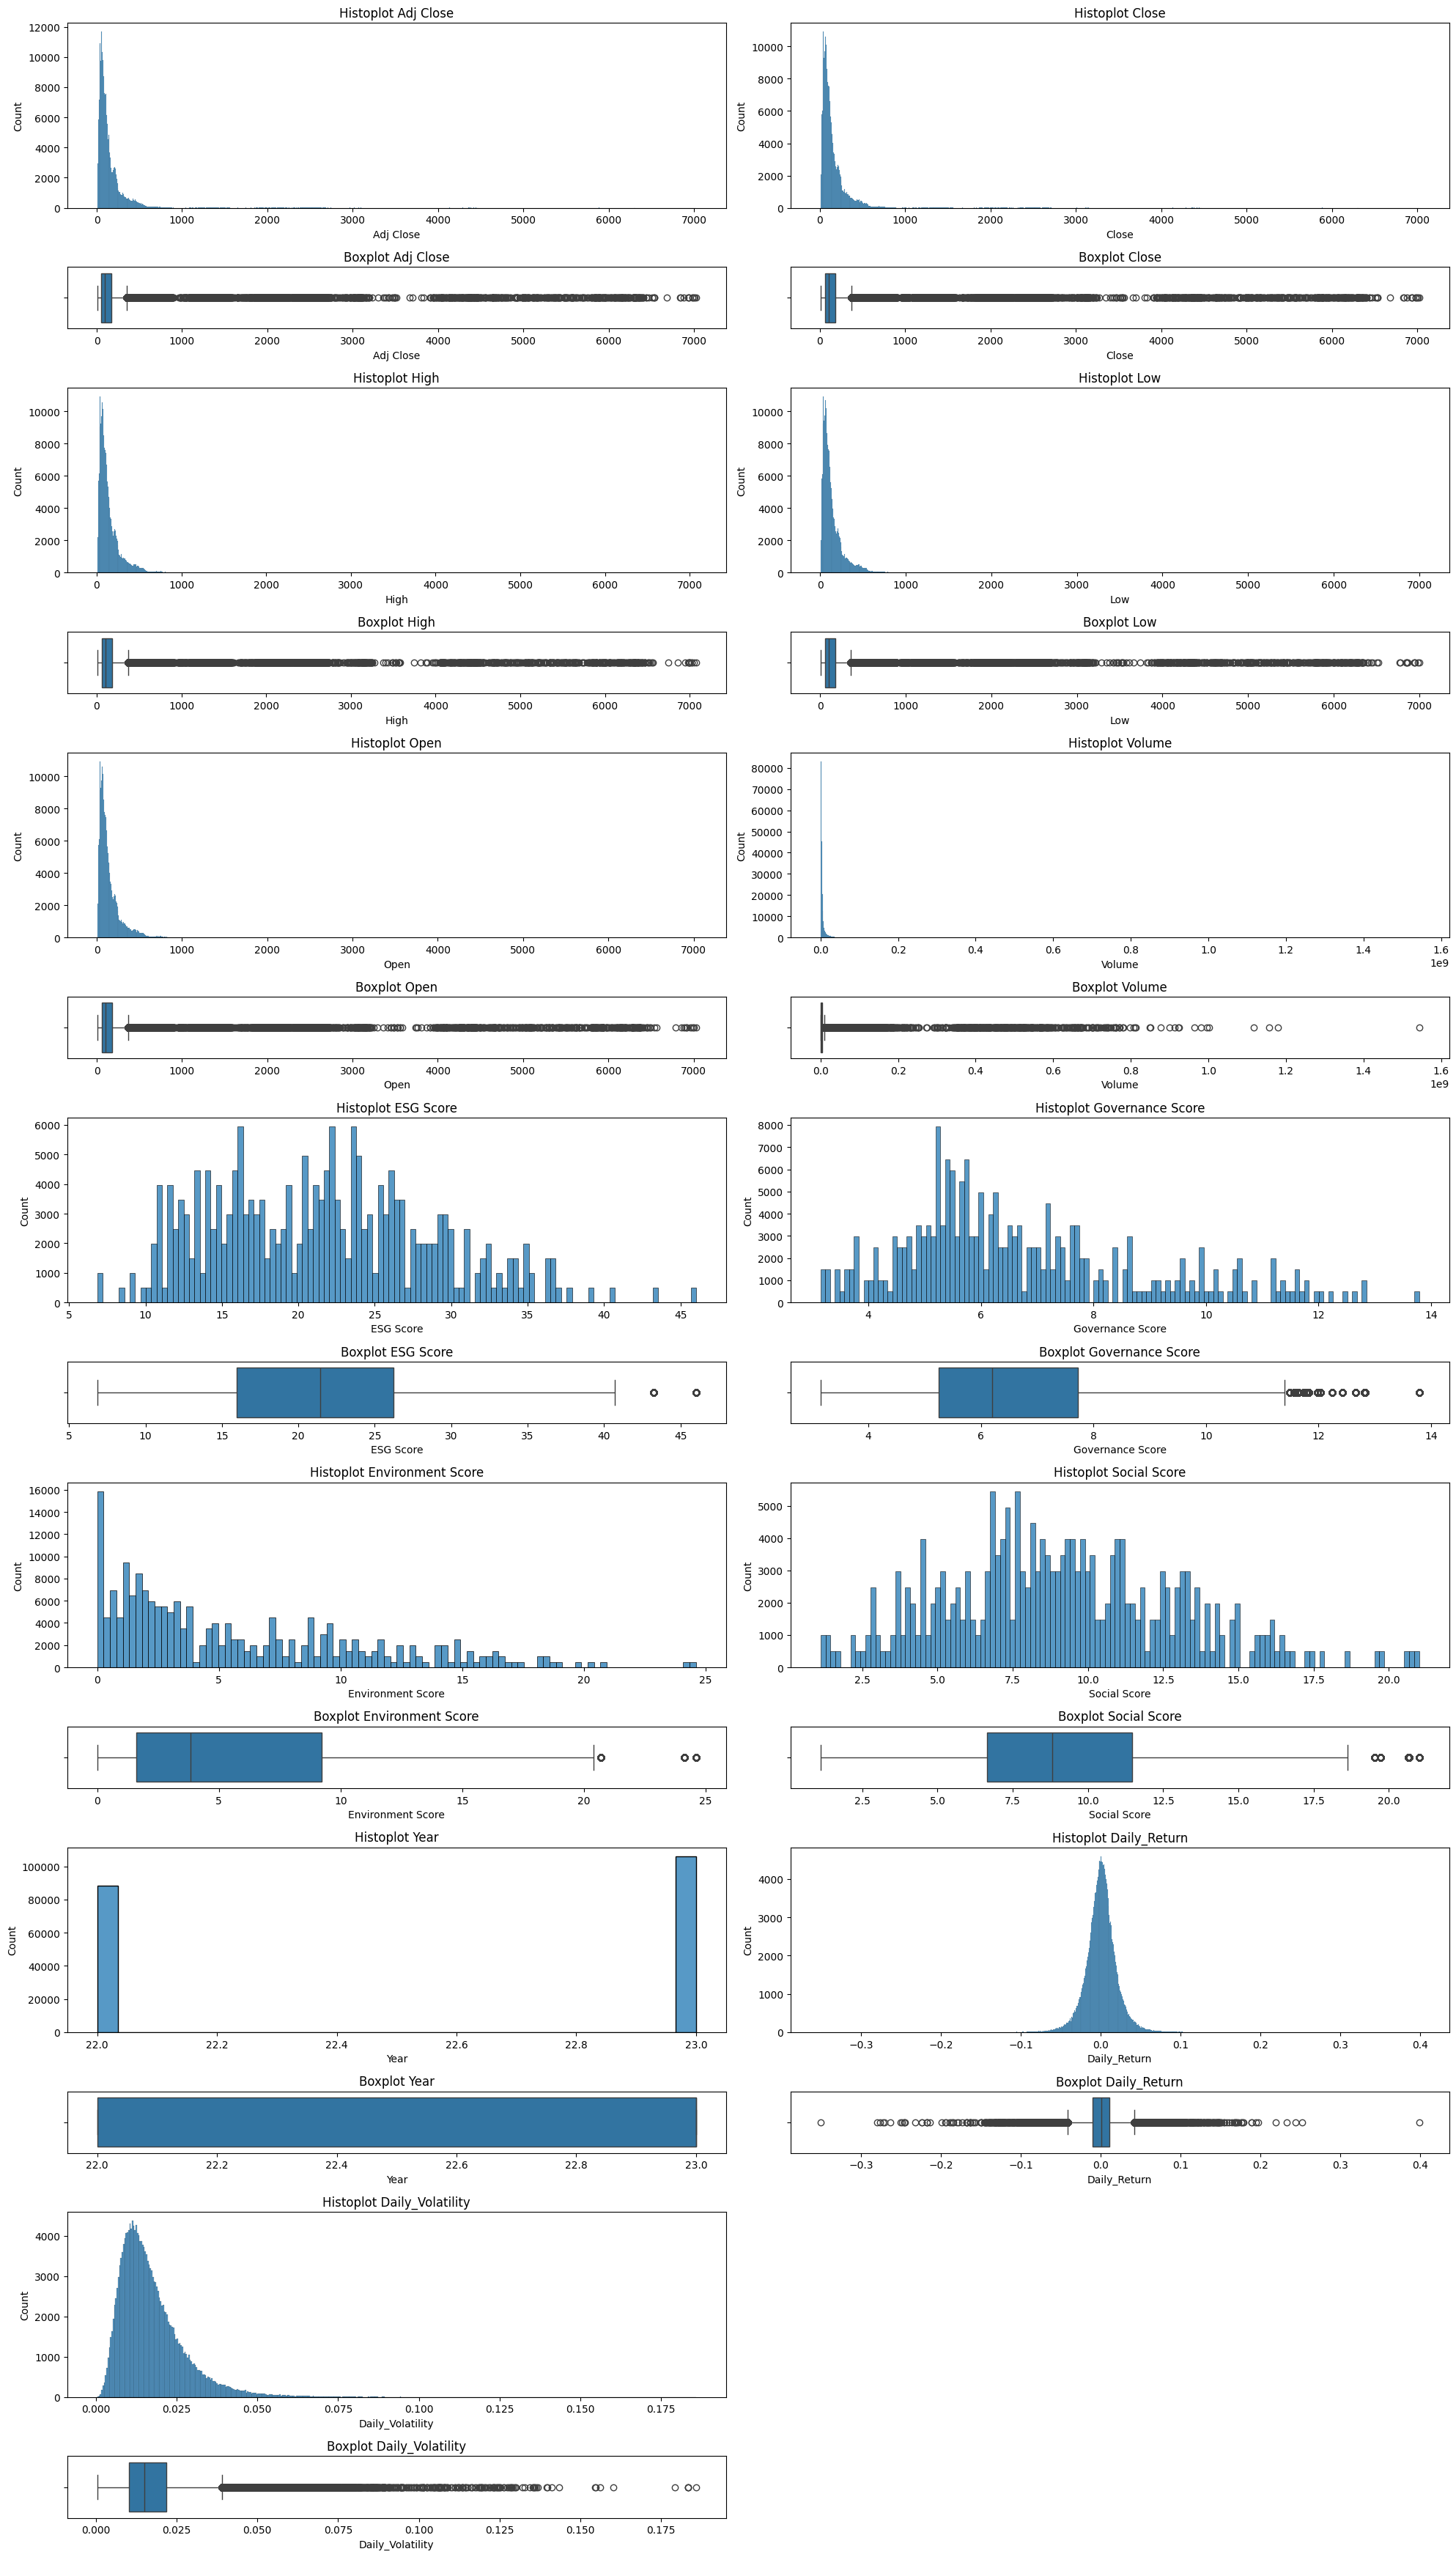

In [21]:
numerical_variables = dataset_final.select_dtypes(include='number').columns
num_vars = len(numerical_variables)

ncols = 2
nrows = num_vars // ncols + (num_vars % ncols)
total_rows = nrows * 2  

fig, axes = plt.subplots(
    nrows=total_rows,
    ncols=ncols,
    figsize=(20, total_rows * 2.5),
    gridspec_kw={"height_ratios": [6, 2] * nrows}
)

axes = axes.reshape(total_rows, ncols)

# Automatic plot
for i, var in enumerate(numerical_variables):
    row = (i // ncols) * 2
    col = i % ncols

    # Histoplot
    sns.histplot(data=dataset_final, x=var, ax=axes[row, col])
    axes[row, col].set_title(f"Histoplot {var}")

    # Boxplot
    sns.boxplot(data=dataset_final, x=var, ax=axes[row + 1, col])
    axes[row + 1, col].set_title(f"Boxplot {var}")

# 🔹 Apagar ejes no usados
for j in range(i + 1, nrows * ncols):
    row = (j // ncols) * 2
    col = j % ncols
    axes[row, col].axis("off")
    axes[row + 1, col].axis("off")

plt.tight_layout()
plt.show()



**Conclusions**:

- **Adj Close, Close, High, Low, Open (Price Features)**: Distributions are heavily right-skewed with most values clustered at the lower end and many extreme outliers stretching to very high prices. 

- **Volume**: Extremely right-skewed with a majority of low-volume observations and very large outliers in trading activity.

- **ESG Score**: Distribution is spread across discrete values with peaks around 20–25. The spread is relatively uniform, with few significant outliers.

- **Governance Score**: Fairly symmetrical distribution, centered around 5–8, with no extreme outliers.

- **Environment Score**: Right-skewed distribution, concentrated at low values (0–5), with some outliers at higher scores.

- **Social Score**: Values are more evenly spread, with some clustering at lower scores and a few mild outliers.

- **Year**: The dataset only spans a very short time window, specifically between 2022 and 2023. No outliers are present, confirming that all observations fall neatly within this two-year range.

- **Daily Return**: Distribution is centered around 0, approximately symmetric but with heavy tails and many extreme values (both positive and negative).

- **Daily Volatility**: Right-skewed, with most values between 0–0.05 and a long tail of outliers showing high volatility periods.

### **Categorical Variables - Analysis and Conclusions**

In [26]:
# CATEGORICALS

categorical_variables = dataset_final.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Variables:", categorical_variables)

Categorical Variables: ['Ticker', 'ESG Score Date', 'ESG Status', 'CEO Gender', 'ESG_Group']


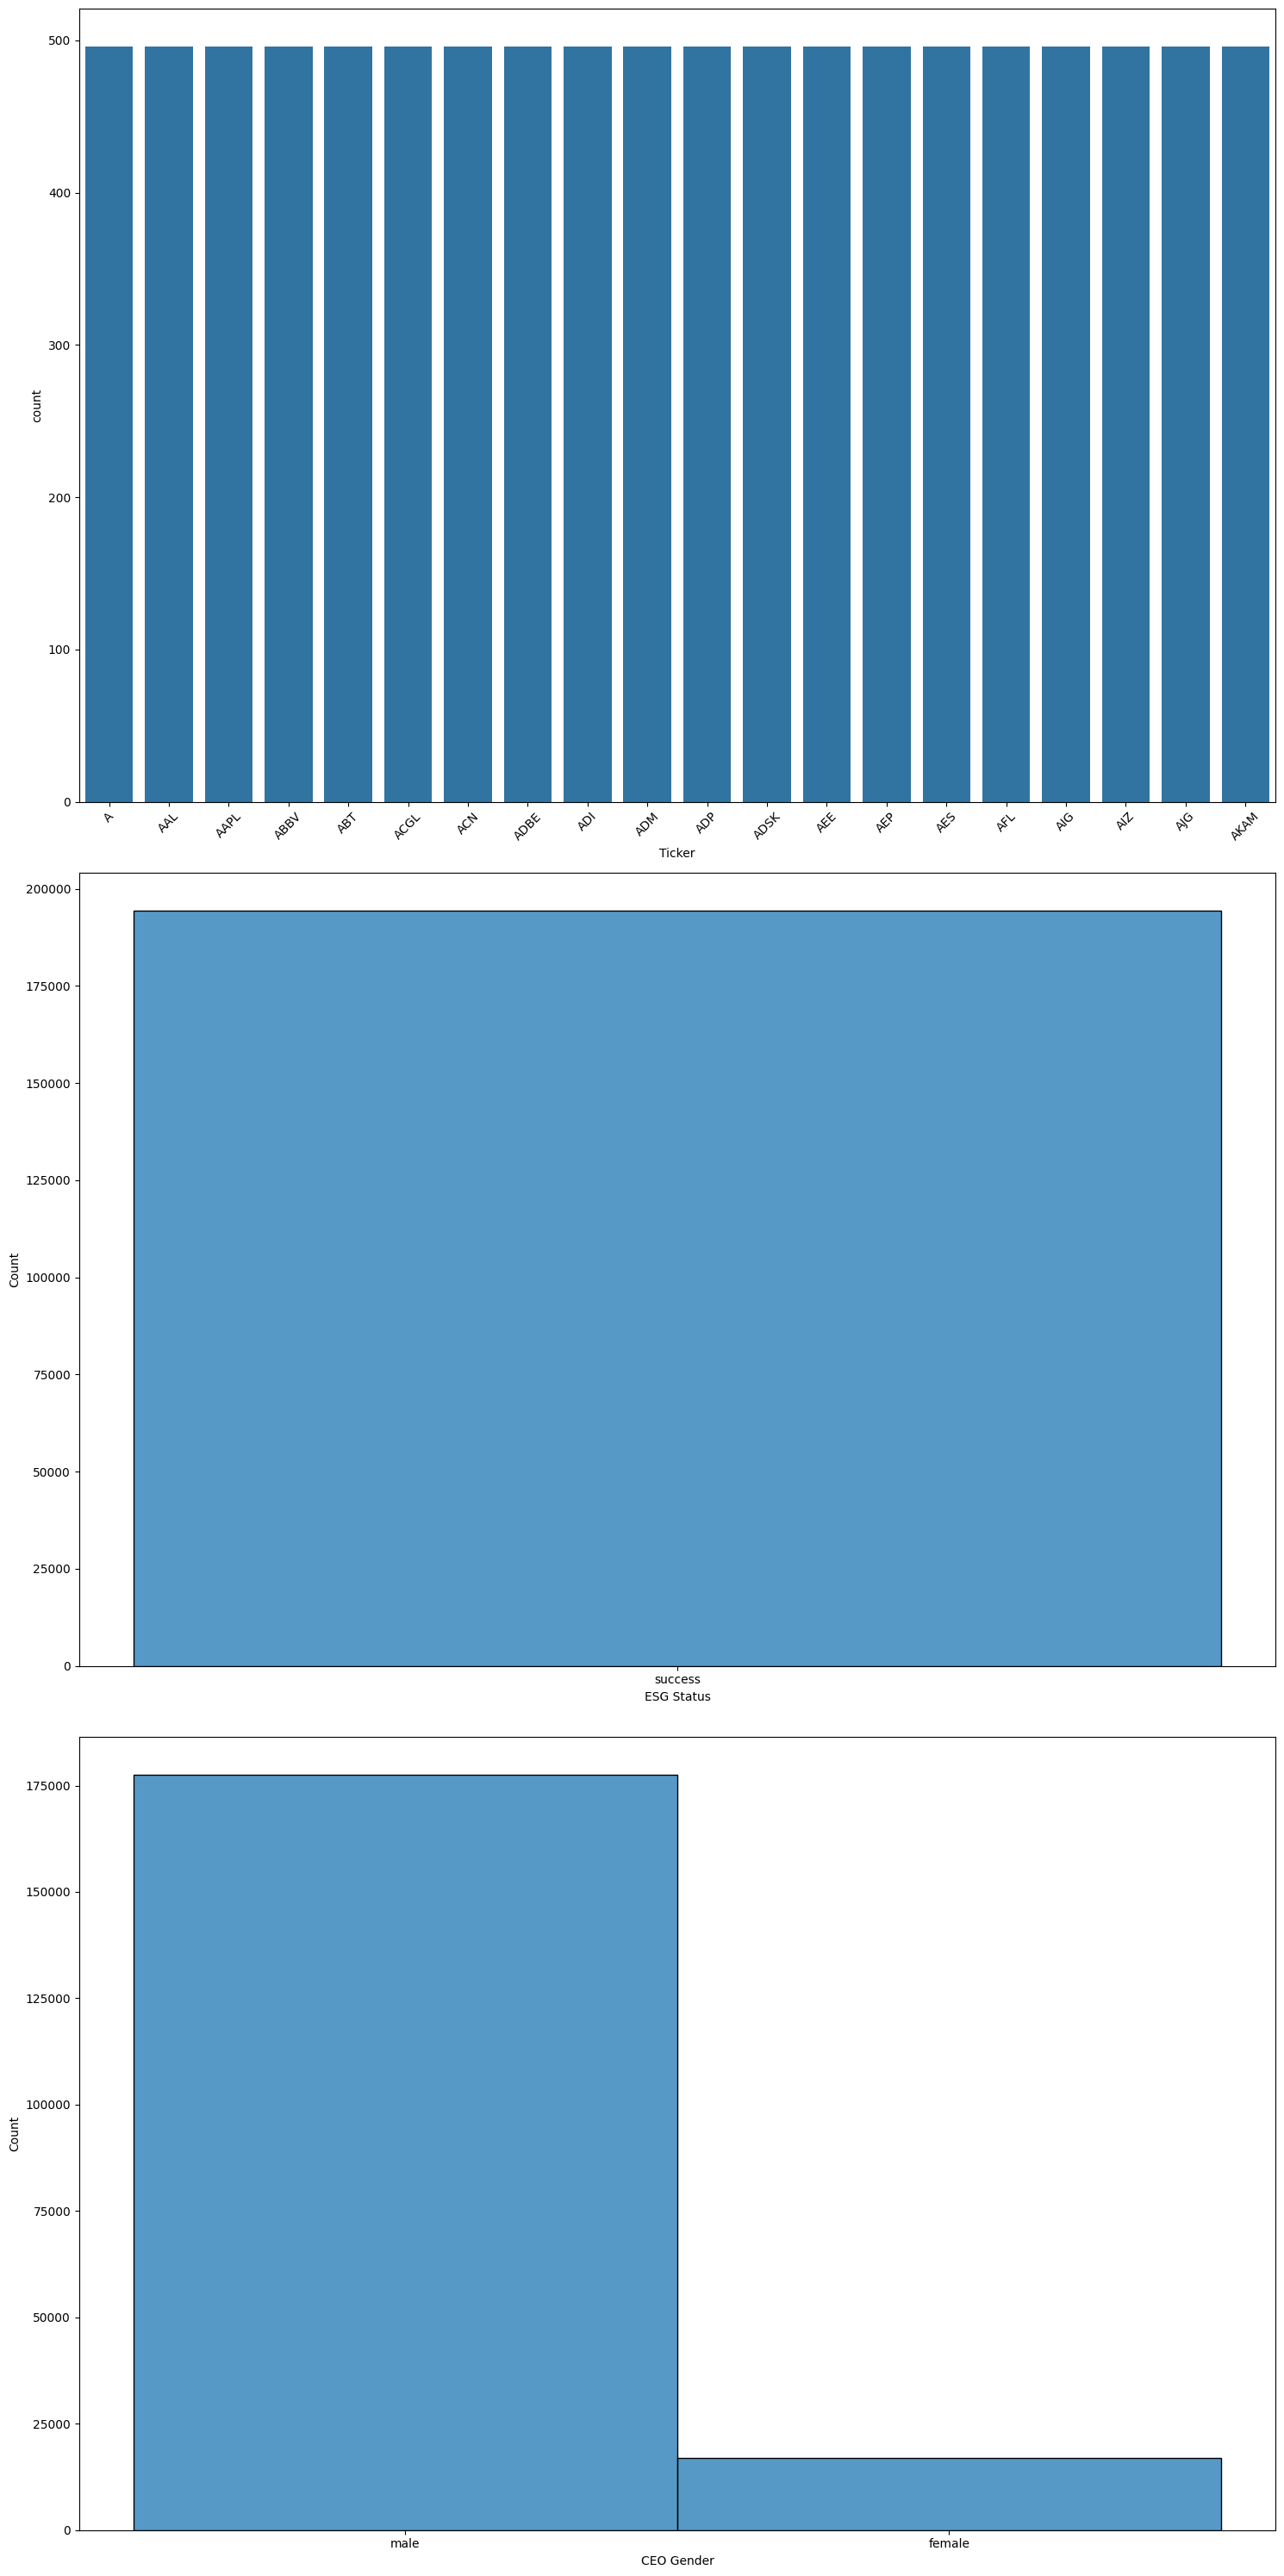

In [ ]:
fig, axis = plt.subplots(3, figsize=(15, 30))

top_tickers = dataset_final["Ticker"].value_counts().nlargest(20).index
sns.countplot(ax=axis[0], data=dataset_final[dataset_final["Ticker"].isin(top_tickers)], x="Ticker")
axis[0].tick_params(axis='x', rotation=45)
sns.histplot(ax = axis[1], data = dataset_final, x = "ESG Status")
sns.histplot(ax = axis[2], data = dataset_final, x = "CEO Gender")

plt.tight_layout()
plt.show()

**Conclusions**: 

- **Ticker Distribution (Top 20)**: Among the 20 most frequent tickers, each company appears with almost identical representation (around 1,900 records each). The dataset is therefore highly balanced across companies, with no single ticker dominating the sample. This balance suggests that the data collection process ensured equal weighting between firms,

- **ESG Status**: All records show “success” as the ESG Status. There is no variation. This feature provides no predictive power (constant variable).

- **CEO Gender**: Strong imbalance: the majority of CEOs are male, with a much smaller proportion being female.

## **Multivariate Analysis**

### **Numerical vs Numerical Analysis**

In [22]:
numerical_variables

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'ESG Score',
       'Governance Score', 'Environment Score', 'Social Score', 'Year',
       'Daily_Return', 'Daily_Volatility'],
      dtype='object')

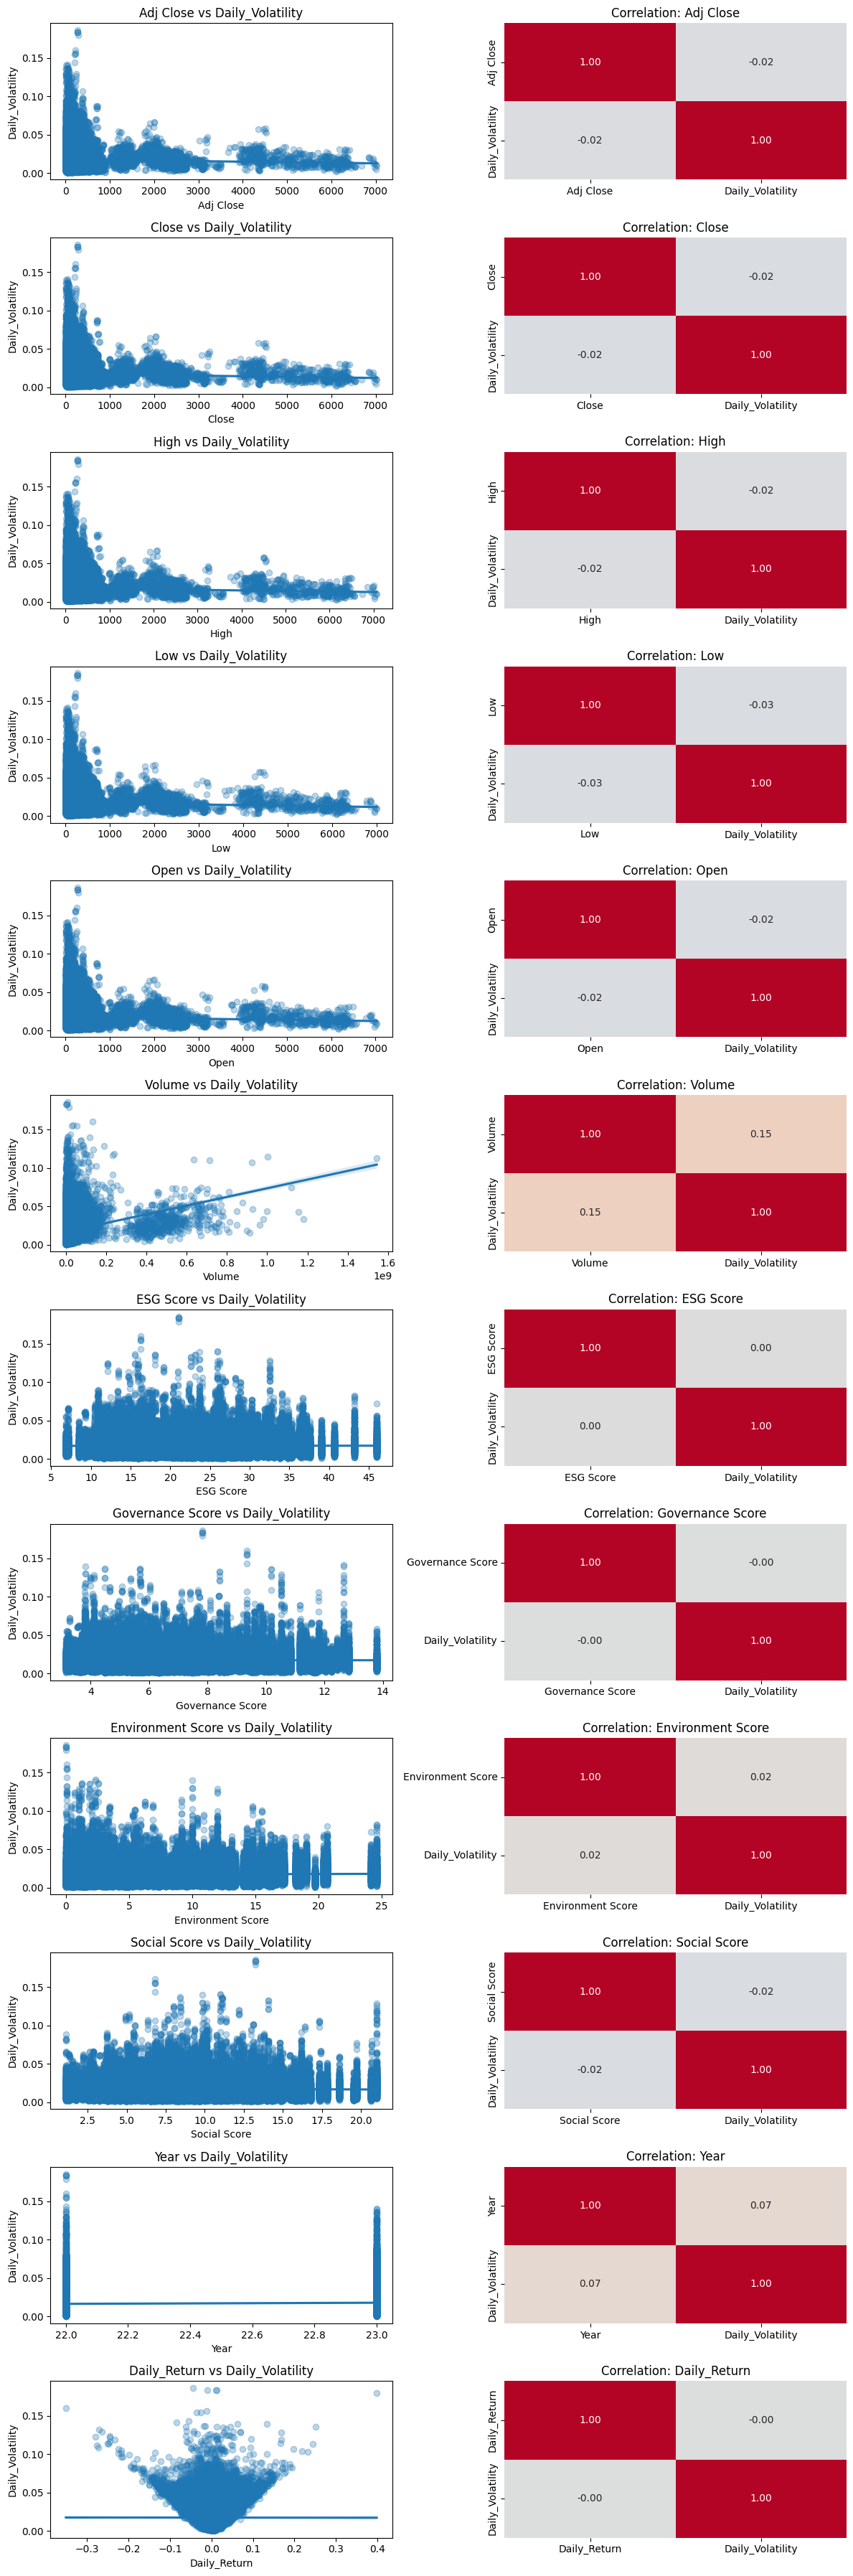

In [23]:
# Variables to compare with Daily_Volatility
variables = [
    "Adj Close", "Close", "High", "Low", "Open", "Volume",
    "ESG Score", "Governance Score", "Environment Score",
    "Social Score", "Year", "Daily_Return"
]

n_vars = len(variables)
ncols = 2   
nrows = n_vars  

fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(12, nrows * 3)
)

# If there's only 1 row, convert axes to 2D to avoid errors
if nrows == 1:
    axes = [axes]

for i, var in enumerate(variables):
    # Regplot on the left
    sns.regplot(
        ax=axes[i, 0], 
        data=dataset_final, 
        x=var, 
        y="Daily_Volatility", 
        scatter_kws={"alpha": 0.3}
    )
    axes[i, 0].set_title(f"{var} vs Daily_Volatility")

    # Heatmap on the right
    corr = dataset_final[[var, "Daily_Volatility"]].corr()
    sns.heatmap(
        corr, 
        annot=True, 
        fmt=".2f", 
        ax=axes[i, 1], 
        cbar=False, 
        cmap="coolwarm",
        vmin=-1, vmax=1
    )
    axes[i, 1].set_title(f"Correlation: {var}")

plt.tight_layout()
plt.show()


**Conclusions**:

- **Price Variables (Adj Close, Close, High, Low, Open)**: All show a negative correlation (~ -0.05) with Daily Volatility. Scatterplots reveal that as stock prices increase, volatility tends to decrease slightly. This suggests that higher-priced stocks exhibit more stability, while lower-priced stocks are relatively more volatile.

- **Volume**: Shows a positive correlation (0.15) with Daily Volatility. Scatterplot indicates that higher trading volume is somewhat associated with higher volatility. This aligns with market behavior: when trading activity surges, price fluctuations intensify.

- **ESG Score**: Very weak negative correlation (-0.02) with volatility. Scatterplot shows no clear trend. ESG performance does not meaningfully explain short-term volatility.

- **Governance Score**: Very weak negative correlation (-0.03). Scatterplot shows dispersed points, no trend.

- **Environment Score**: Near-zero correlation (0.01).No visible pattern in the scatterplot. Suggests that environmental factors don’t directly affect daily volatility.

- **Social Score**: Weak negative correlation (-0.03). Similar to Governance and ESG Score — no significant relationship. Indicates social factors are not linked to short-term volatility.

- **Year**: Slight positive correlation (0.07) with volatility. Scatterplot shows changes in volatility across years, possibly due to macroeconomic events or crises. Suggests that market conditions vary across years, impacting volatility moderately.

- **Daily Return**: Very weak positive correlation (0.01) with volatility. Scatterplot shows the expected pattern: higher absolute returns often coincide with higher volatility. Indicates that price jumps (positive or negative) usually increase volatility.

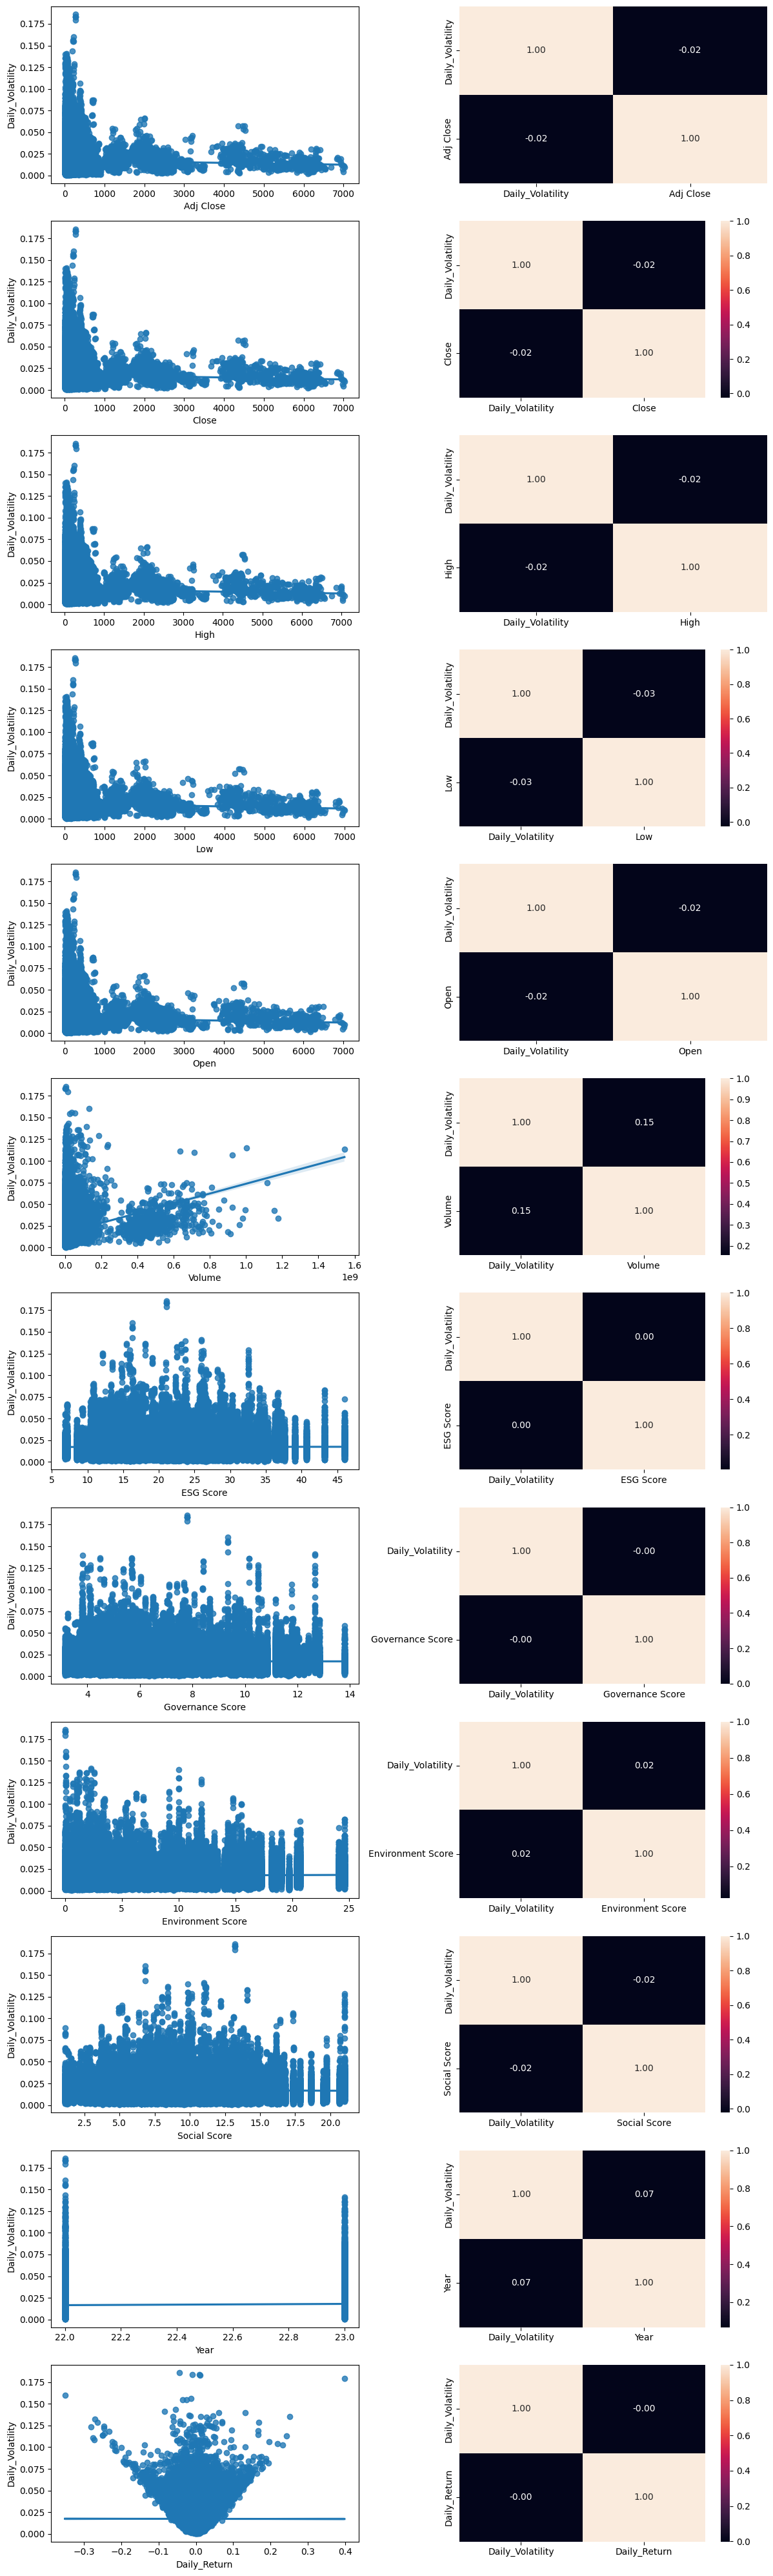

In [ ]:
fig, axis = plt.subplots(12, 2, figsize=(12, 40))  # 12 variables → 12 filas x 2 columnas

sns.regplot(ax=axis[0, 0], data=dataset_final, x="Adj Close", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Adj Close"]].corr(), annot=True, fmt=".2f", ax=axis[0, 1], cbar=False)

sns.regplot(ax=axis[1, 0], data=dataset_final, x="Close", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Close"]].corr(), annot=True, fmt=".2f", ax=axis[1, 1])

sns.regplot(ax=axis[2, 0], data=dataset_final, x="High", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "High"]].corr(), annot=True, fmt=".2f", ax=axis[2, 1], cbar=False)

sns.regplot(ax=axis[3, 0], data=dataset_final, x="Low", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Low"]].corr(), annot=True, fmt=".2f", ax=axis[3, 1])

sns.regplot(ax=axis[4, 0], data=dataset_final, x="Open", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Open"]].corr(), annot=True, fmt=".2f", ax=axis[4, 1], cbar=False)

sns.regplot(ax=axis[5, 0], data=dataset_final, x="Volume", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Volume"]].corr(), annot=True, fmt=".2f", ax=axis[5, 1])

sns.regplot(ax=axis[6, 0], data=dataset_final, x="ESG Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "ESG Score"]].corr(), annot=True, fmt=".2f", ax=axis[6, 1])

sns.regplot(ax=axis[7, 0], data=dataset_final, x="Governance Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Governance Score"]].corr(), annot=True, fmt=".2f", ax=axis[7, 1])

sns.regplot(ax=axis[8, 0], data=dataset_final, x="Environment Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Environment Score"]].corr(), annot=True, fmt=".2f", ax=axis[8, 1])

sns.regplot(ax=axis[9, 0], data=dataset_final, x="Social Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Social Score"]].corr(), annot=True, fmt=".2f", ax=axis[9, 1])

sns.regplot(ax=axis[10, 0], data=dataset_final, x="Year", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Year"]].corr(), annot=True, fmt=".2f", ax=axis[10, 1])

sns.regplot(ax=axis[11, 0], data=dataset_final, x="Daily_Return", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Daily_Return"]].corr(), annot=True, fmt=".2f", ax=axis[11, 1])

plt.tight_layout()
plt.show()


**Conclusions**:

- **Prices Variables (Adj Close, Close, High, Low, Open)**: Show a very weak negative correlation (-0.05) with daily volatility.Scatterplots suggest that higher stock prices are slightly associated with lower volatility. In short: higher-priced stocks appear more stable, but the relationship is weak.

- **Volume**: Displays the strongest positive correlation (0.15) with daily volatility. Higher trading activity tends to come with higher volatility. This is consistent with financial theory: increased market activity often leads to greater price fluctuations.

- **ESG Scores (ESG, Governance, Environment, Social)**: All correlations are close to zero (between -0.02 and -0.03).Scatterplots show no clear pattern. ESG factors do not exhibit a noticeable linear relationship with daily volatility.

- **Year**: Shows a very small positive correlation (0.07) with daily volatility. This suggests that volatility has varied slightly over time, possibly due to crises, regulatory changes, or macroeconomic shocks.

- **Daily Return**: Correlation is nearly zero (0.01), but the scatterplot reveals an important insight, extreme returns (large positive or negative) tend to coincide with higher volatility. This indicates the relationship is non-linear, but expected: sharp price movements usually bring higher volatility.

### **Categorical vs Categorical Analysis**

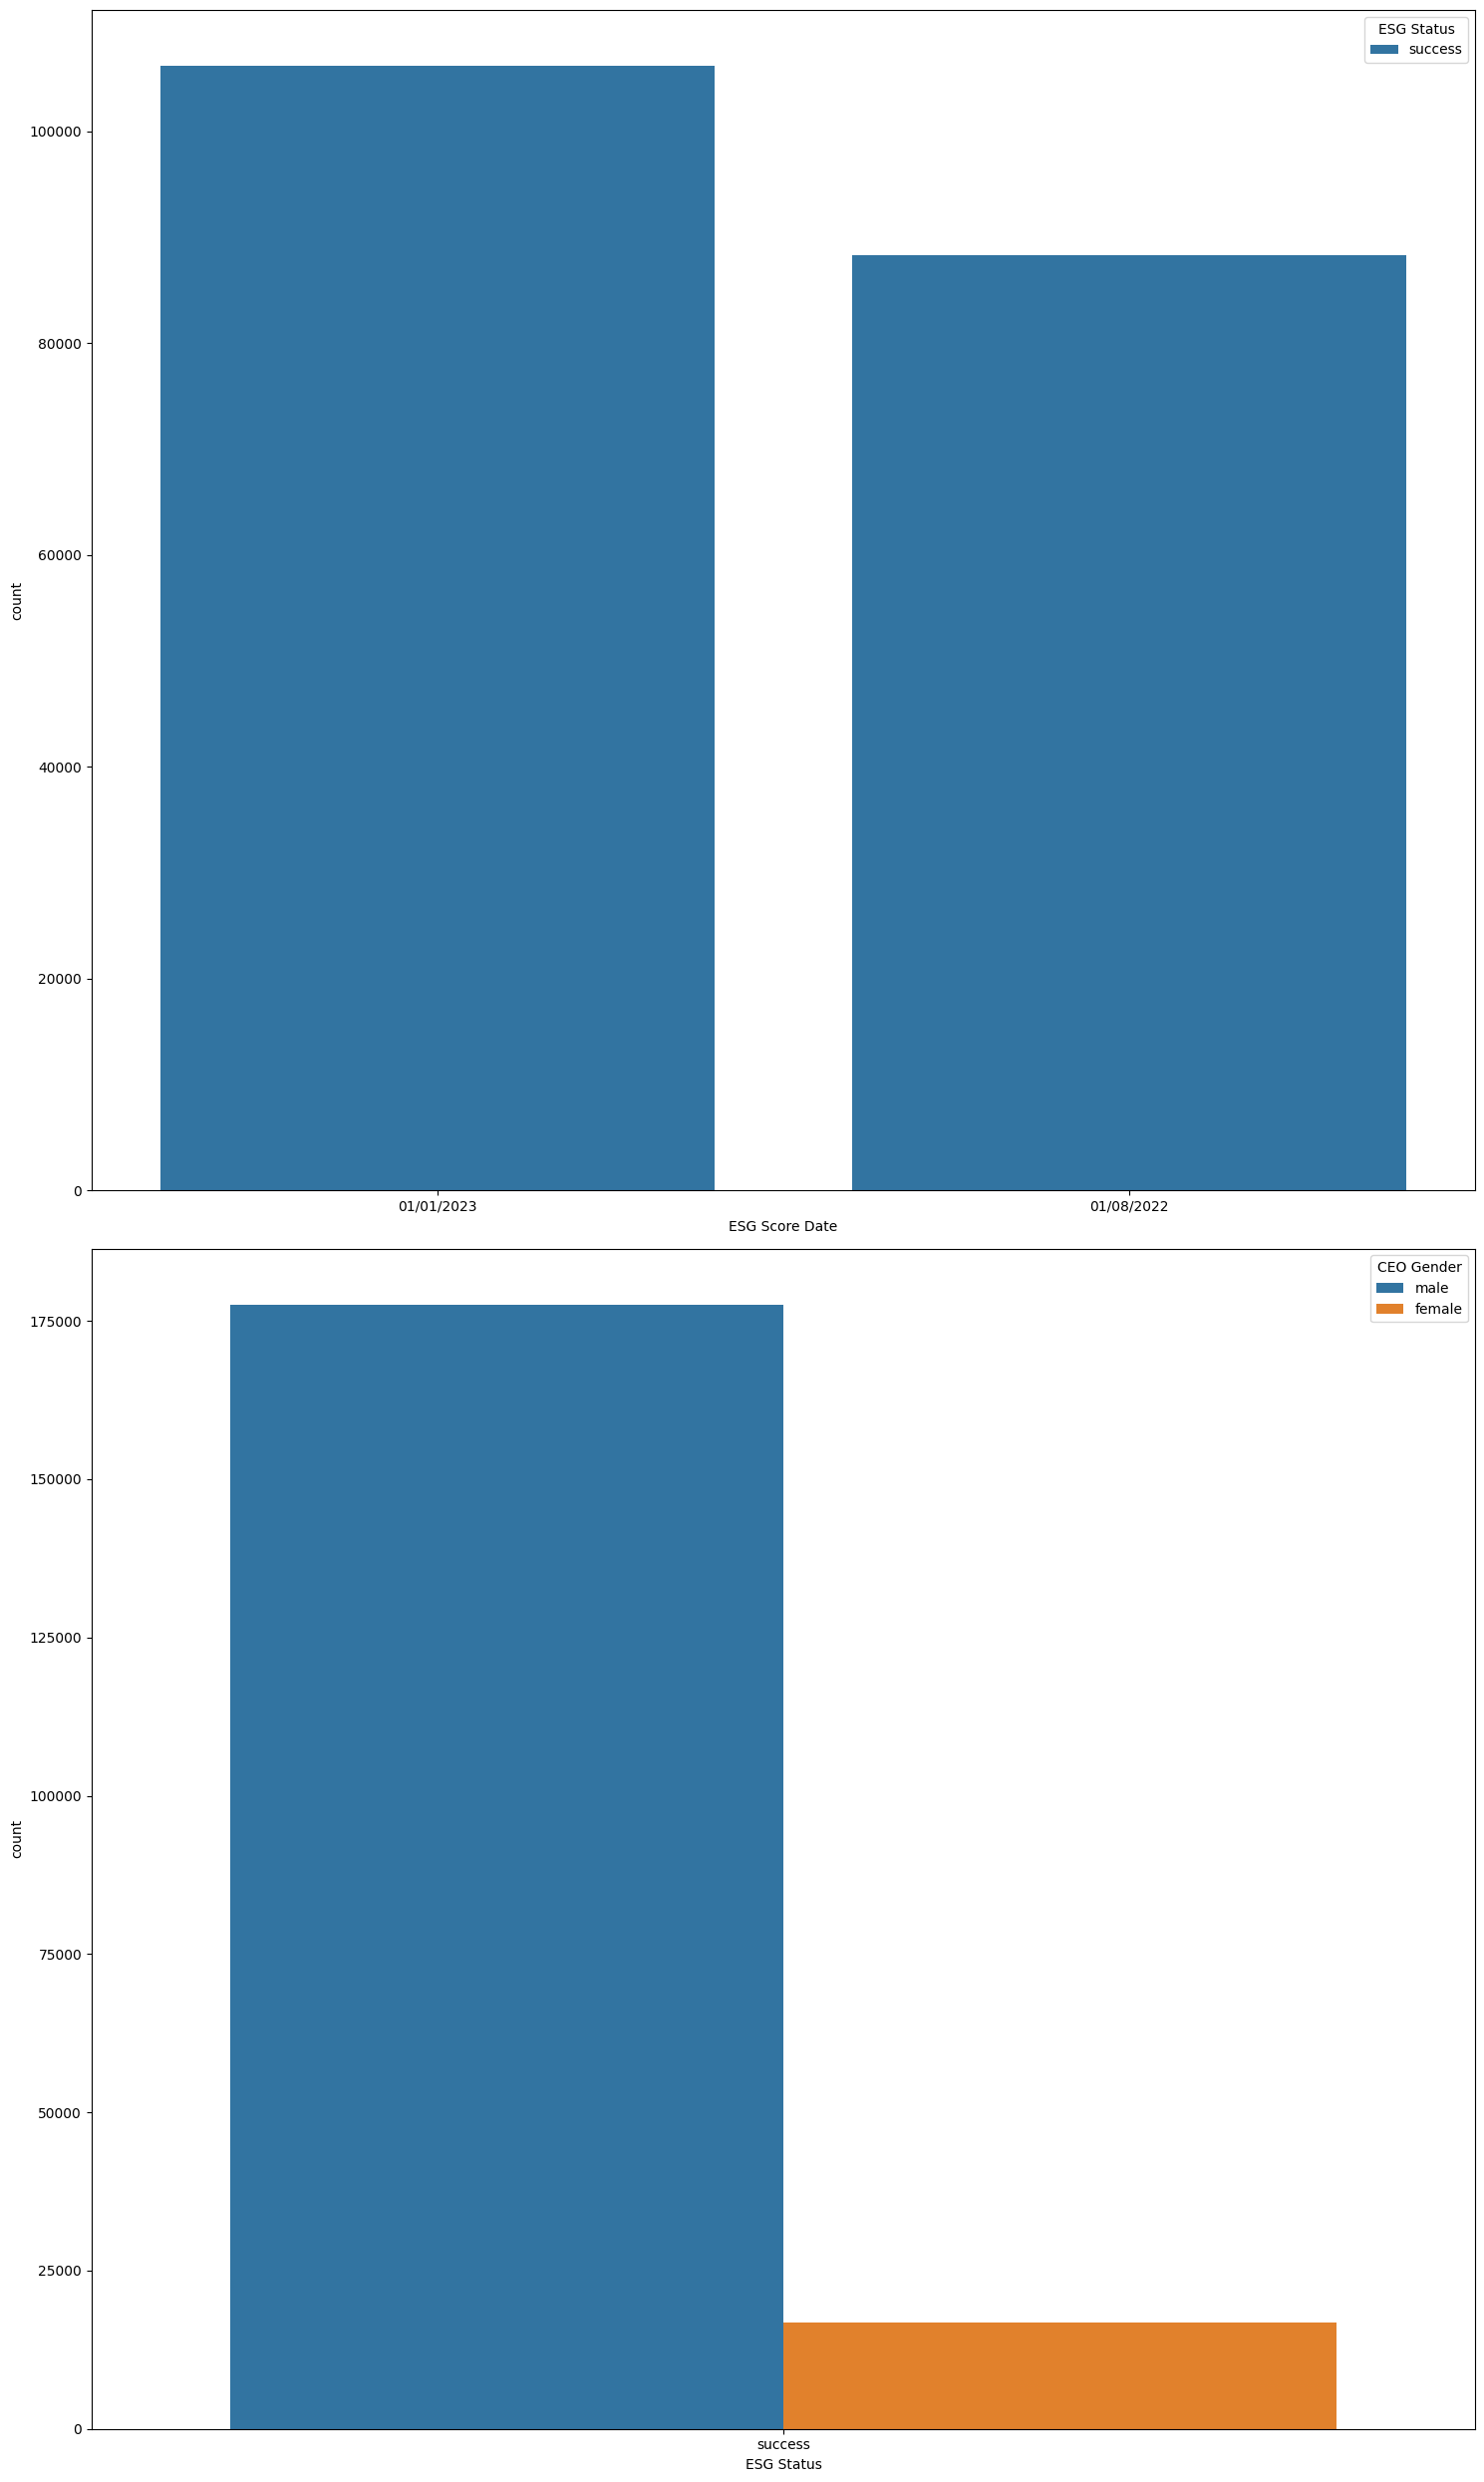

In [ ]:
fig, axis = plt.subplots(2, 1, figsize=(15, 15))  

sns.countplot(data=dataset_final, x="ESG Score Date", hue="ESG Status", ax=axis[0])
sns.countplot(data=dataset_final, x="ESG Status", hue="CEO Gender", ax=axis[1])

plt.tight_layout()
plt.show()


**Conclusions**:

- The bottom plot shows the relationship between ESG Status and CEO Gender. Given that ESG Status is uniform, this plot highlights the severe imbalance in the CEO Gender category. The dataset contains a significantly larger number of entries for male CEOs compared to female CEOs

<Axes: xlabel='CEO Gender', ylabel='Daily_Volatility'>

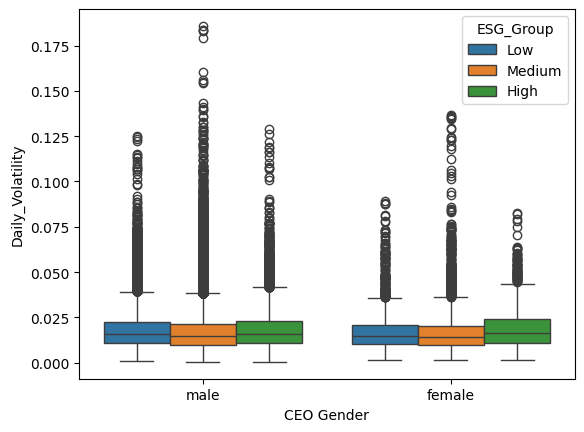

In [24]:
dataset_final["ESG_Group"] = pd.cut(dataset_final["ESG Score"], bins=[0,15,30,45], labels=["Low","Medium","High"])
sns.boxplot(data=dataset_final, x="CEO Gender", y="Daily_Volatility", hue="ESG_Group")

**Conclusions**:

- **Daily Volatility across CEO Gender**: Both male- and female-led firms exhibit broadly similar levels of daily volatility. There is no substantial difference in the median or interquartile ranges between the two groups.

- **Effect of ESG Score Grouping**: Within each gender, the distribution of volatility does not vary greatly between the Low, Medium, and High ESG groups. The medians are close, and the spread of values is largely overlapping.

- **Outliers**: A considerable number of outliers are present in both genders and across ESG groups, indicating that while most firms cluster within a narrow volatility range, some experience unusually high daily fluctuations.

Neither CEO gender nor ESG grouping appears to drive a major shift in daily volatility, suggesting that other factors may play a more decisive role in determining stock price stability.

# ANÁLISIS DE CORRELACIONES

In [27]:
categorical_f_rules = {}

for col in categorical_variables:
    encoded_col = f"{col}_n"
    dataset_final[encoded_col], uniques = pd.factorize(dataset_final[col])
    dicc = dict(zip(uniques, range(len(uniques))))
    categorical_f_rules[col] = dicc

with open("categorical_rules.json", "w") as f:
    json.dump(categorical_f_rules, f)

with open("categorical_rules.json", "r") as f:
    loaded_mappings = json.load(f)

dataset_final.head()

Date Ticker   Adj Close       Close        High         Low  \
1960 2022-01-10      A  141.584717  145.160004  145.309998  140.860001   
1961 2022-01-10    AAL   18.790001   18.790001   19.389999   18.680000   
1962 2022-01-10   AAPL  168.815552  172.190002  172.500000  168.169998   
1963 2022-01-10   ABBV  118.463676  136.389999  136.899994  134.570007   
1964 2022-01-10    ABT  126.047211  135.259995  135.500000  133.919998   

            Open       Volume  ESG Score  Governance Score  ...  CEO Gender  \
1960  143.289993    2548100.0      15.24              6.26  ...        male   
1961   19.240000   25707700.0      29.10              5.26  ...        male   
1962  169.080002  106765600.0      16.68              9.18  ...        male   
1963  135.080002    9794400.0      27.84              9.95  ...        male   
1964  134.789993    5975600.0      24.98              8.36  ...        male   

      Year Daily_Return Daily_Volatility ESG_Group  Ticker_n  \
1960    23     0.000069         0.016297    Medium         0   
1961    23    -0.025415         0.025821    Medium         1   
1962    22     0.000116         0.011682    Medium         2   
1963    22     0.011195         0.006615    Medium         3   
1964    22    -0.002213         0.010479    Medium         4   

      ESG Score Date_n  ESG Status_n CEO Gender_n  ESG_Group_n  
1960                 0             0            0            0  
1961                 0             0            0            0  
1962                 1             0            0            0  
1963                 1             0            0            0  
1964                 1             0            0            0  

[5 rows x 24 columns]

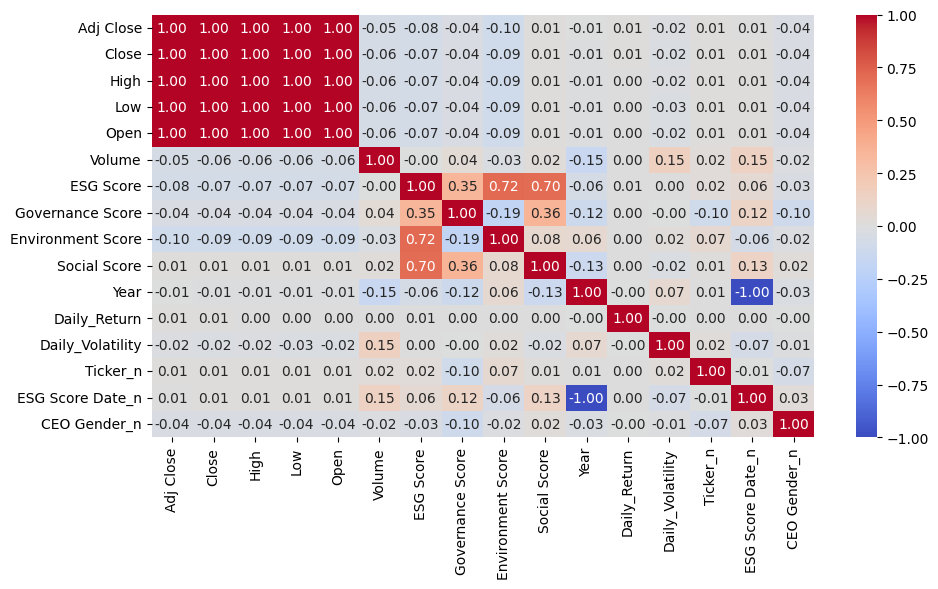

In [ ]:
fig, axis = plt.subplots(figsize=(10, 6))

sns.heatmap(
    dataset_final[[
        "Adj Close", "Close", "High", "Low", "Open", "Volume",
        "ESG Score", "Governance Score", "Environment Score", "Social Score",
        "Year", "Daily_Return", "Daily_Volatility",
        "Ticker_n", "ESG Score Date_n",
        "CEO Gender_n"
    ]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)

plt.tight_layout()
plt.show()


**Conclusions**:

- **Stock Price Variables**: Adjusted Close, Close, High, Low, and Open are almost perfectly correlated (correlation ≈ 1.00), which is expected since they are all highly related measures of stock price.

- **Volume**: Trading volume shows very weak negative correlations with price variables and ESG metrics, suggesting little direct relationship.

- **ESG Score Components**: The overall ESG Score is strongly correlated with the Environment (0.72) and Social (0.70) sub-scores, while Governance contributes less strongly (0.35). This indicates that environmental and social factors dominate the overall ESG measure in this dataset.

- **ESG vs Market Variables**: ESG scores display only weak correlations with financial metrics such as returns and volatility, implying limited direct linkage between ESG ratings and short-term market performance.

- **Outliers in Correlation**: The variable Year is negatively correlated with Environment (–0.12) and Social (–0.13), hinting at possible temporal variation in ESG scoring practices.

- **Categorical Encodings**: Numerical encodings for Ticker, ESG Score Date, and CEO Gender show negligible correlations with other variables, as expected since these are identifiers or categorical transformations.

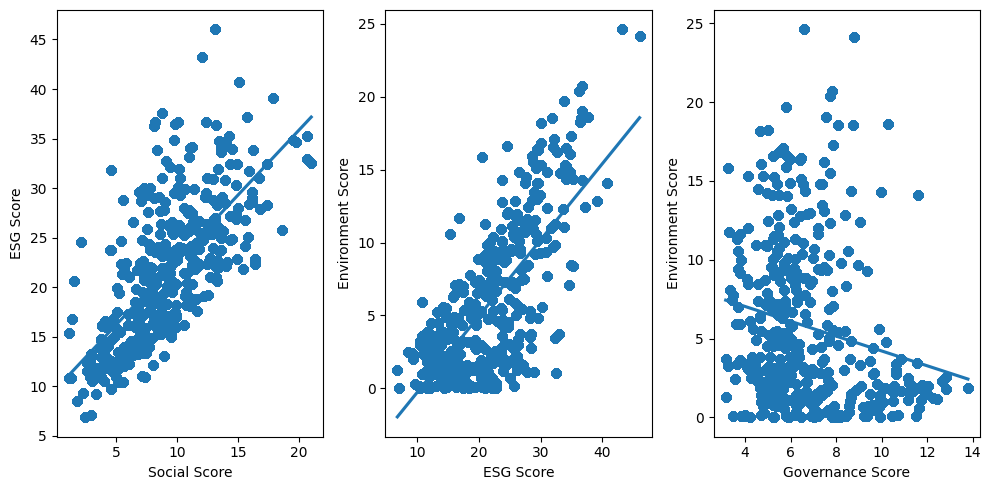

In [ ]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 3)
sns.regplot(ax = axis[0], data = dataset_final, x = "Social Score", y = "ESG Score")
sns.regplot(ax = axis[1], data = dataset_final, x = "ESG Score", y = "Environment Score")
sns.regplot(ax = axis[2], data = dataset_final, x = "Governance Score", y = "Environment Score")

plt.tight_layout()
plt.show()

**Conclusions**:

- **Social Score vs. ESG Score**: The plot of Social Score against ESG Score shows a strong positive correlation. As Social Score is a direct component of the overall ESG Score, a strong positive linear relationship is expected. This means that as a company's social performance improves, its overall ESG score tends to increase significantly.

- **ESG Score vs. Environment Score**: Similarly, the plot of ESG Score against Environment Score would also show a strong positive correlation. This indicates that environmental performance is a major contributor to a company's overall ESG score. A company with a high environmental score is likely to also have a high overall ESG score.

- **Governance Score vs. Environment Score**: The plot of Governance Score against Environment Score reveals a weak negative relationship. This is a fascinating and unexpected finding. It suggests that companies with a higher Governance Score may, on average, have a lower Environment Score.

## **Analysing all the Data at Once**


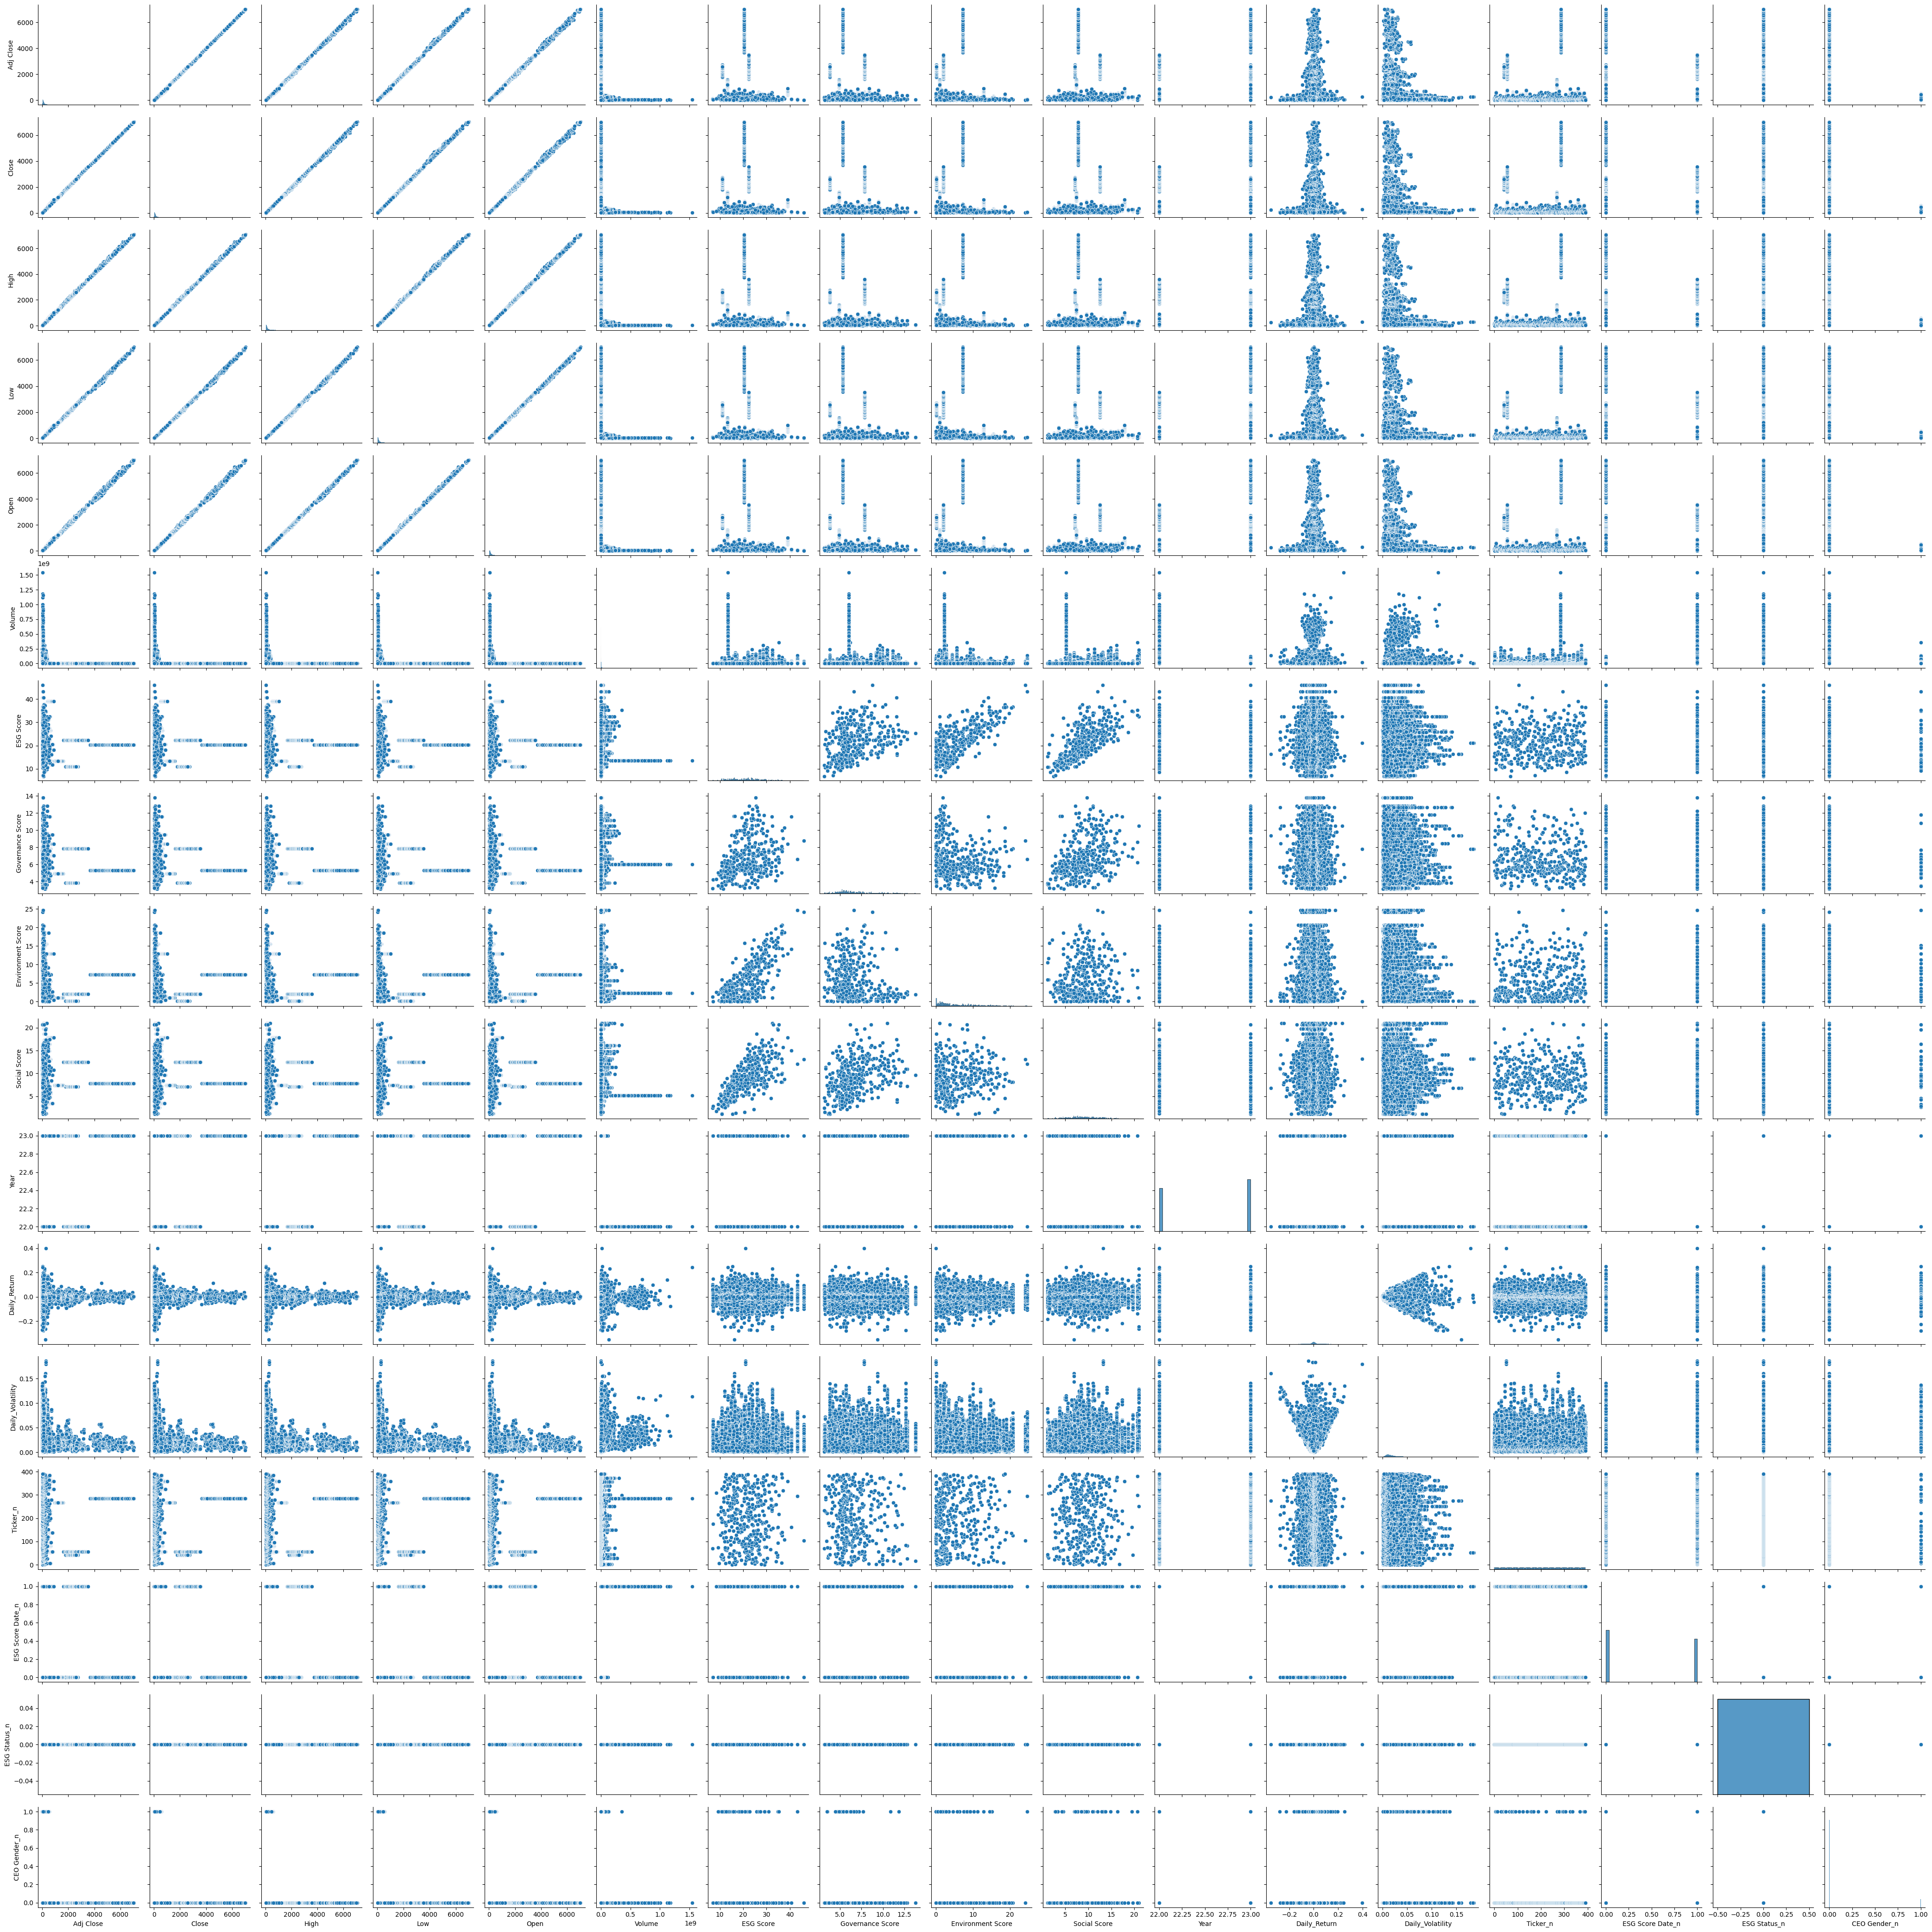

In [ ]:
sns.pairplot(data = dataset_final)

**Conclusions**:

The diagonal plots confirm the distributions seen in previous plots:

Daily_Return and Daily_Volatility have highly skewed distributions with a strong concentration of data around zero. The long tails indicate the presence of significant outliers, which are common and meaningful in financial data.

ESG Score has a more spread-out distribution, with a wider range of values.

Volume is extremely skewed, with most data points clustered at low values and a long tail of outliers representing days with very high trading activity.

In [ ]:
dataset_final.describe()

Date      Adj Close          Close  \
count                         194432  194432.000000  194432.000000   
mean   2023-01-04 06:52:15.483870720     160.944743     167.388926   
min              2022-01-10 00:00:00       6.380000       6.380000   
25%              2022-07-10 06:00:00      54.927226      58.689999   
50%              2023-01-04 12:00:00      95.655643     101.309998   
75%              2023-07-05 06:00:00     172.638741     181.679993   
max              2023-12-29 00:00:00    7024.819824    7024.819824   
std                              NaN     331.436344     332.953698   

                High            Low           Open        Volume  \
count  194432.000000  194432.000000  194432.000000  1.944320e+05   
mean      169.368992     165.331806     167.345709  6.552061e+06   
min         6.740000       6.110000       6.420000  6.400000e+03   
25%        59.419998      57.950001      58.709999  1.071500e+06   
50%       102.559998      99.980003     101.260002  2.154600e+06   
75%       183.779999     179.509995     181.639999  4.925325e+06   
max      7075.000000    6997.910156    7028.500000  1.543911e+09   
std       336.914249     328.891816     332.770562  2.884069e+07   

           ESG Score  Governance Score  Environment Score   Social Score  \
count  194432.000000     194432.000000      194432.000000  194432.000000   
mean       21.568444          6.717755           5.755510       9.095230   
min         6.840000          3.150000           0.000000       1.110000   
25%        15.940000          5.250000           1.595000       6.647500   
50%        21.435000          6.205000           3.820000       8.810000   
75%        26.242500          7.722500           9.215000      11.462500   
max        46.020000         13.790000          24.610000      21.010000   
std         7.112719          2.142073           5.206709       3.787409   

                Year   Daily_Return  Daily_Volatility       Ticker_n  \
count  194432.000000  194432.000000     194432.000000  194432.000000   
mean       22.545918       0.000226          0.017352     195.500000   
min        22.000000      -0.351166          0.000479       0.000000   
25%        22.000000      -0.010178          0.010248      97.750000   
50%        23.000000       0.000344          0.014977     195.500000   
75%        23.000000       0.010650          0.021751     293.250000   
max        23.000000       0.398503          0.185806     391.000000   
std         0.497888       0.020220          0.010542     113.160576   

       ESG Score Date_n  ESG Status_n   CEO Gender_n  
count     194432.000000      194432.0  194432.000000  
mean           0.454082           0.0       0.086735  
min            0.000000           0.0       0.000000  
25%            0.000000           0.0       0.000000  
50%            0.000000           0.0       0.000000  
75%            1.000000           0.0       0.000000  
max            1.000000           0.0       1.000000  
std            0.497888           0.0       0.281447

## **Feature Engineering**

### **Outliers Analysis**

In [ ]:
dataset_final.describe()

Date      Adj Close          Close  \
count                         194432  194432.000000  194432.000000   
mean   2023-01-04 06:52:15.483870720     160.944743     167.388926   
min              2022-01-10 00:00:00       6.380000       6.380000   
25%              2022-07-10 06:00:00      54.927226      58.689999   
50%              2023-01-04 12:00:00      95.655643     101.309998   
75%              2023-07-05 06:00:00     172.638741     181.679993   
max              2023-12-29 00:00:00    7024.819824    7024.819824   
std                              NaN     331.436344     332.953698   

                High            Low           Open        Volume  \
count  194432.000000  194432.000000  194432.000000  1.944320e+05   
mean      169.368992     165.331806     167.345709  6.552061e+06   
min         6.740000       6.110000       6.420000  6.400000e+03   
25%        59.419998      57.950001      58.709999  1.071500e+06   
50%       102.559998      99.980003     101.260002  2.154600e+06   
75%       183.779999     179.509995     181.639999  4.925325e+06   
max      7075.000000    6997.910156    7028.500000  1.543911e+09   
std       336.914249     328.891816     332.770562  2.884069e+07   

           ESG Score  Governance Score  Environment Score   Social Score  \
count  194432.000000     194432.000000      194432.000000  194432.000000   
mean       21.568444          6.717755           5.755510       9.095230   
min         6.840000          3.150000           0.000000       1.110000   
25%        15.940000          5.250000           1.595000       6.647500   
50%        21.435000          6.205000           3.820000       8.810000   
75%        26.242500          7.722500           9.215000      11.462500   
max        46.020000         13.790000          24.610000      21.010000   
std         7.112719          2.142073           5.206709       3.787409   

                Year   Daily_Return  Daily_Volatility       Ticker_n  \
count  194432.000000  194432.000000     194432.000000  194432.000000   
mean       22.545918       0.000226          0.017352     195.500000   
min        22.000000      -0.351166          0.000479       0.000000   
25%        22.000000      -0.010178          0.010248      97.750000   
50%        23.000000       0.000344          0.014977     195.500000   
75%        23.000000       0.010650          0.021751     293.250000   
max        23.000000       0.398503          0.185806     391.000000   
std         0.497888       0.020220          0.010542     113.160576   

       ESG Score Date_n  ESG Status_n   CEO Gender_n  
count     194432.000000      194432.0  194432.000000  
mean           0.454082           0.0       0.086735  
min            0.000000           0.0       0.000000  
25%            0.000000           0.0       0.000000  
50%            0.000000           0.0       0.000000  
75%            1.000000           0.0       0.000000  
max            1.000000           0.0       1.000000  
std            0.497888           0.0       0.281447

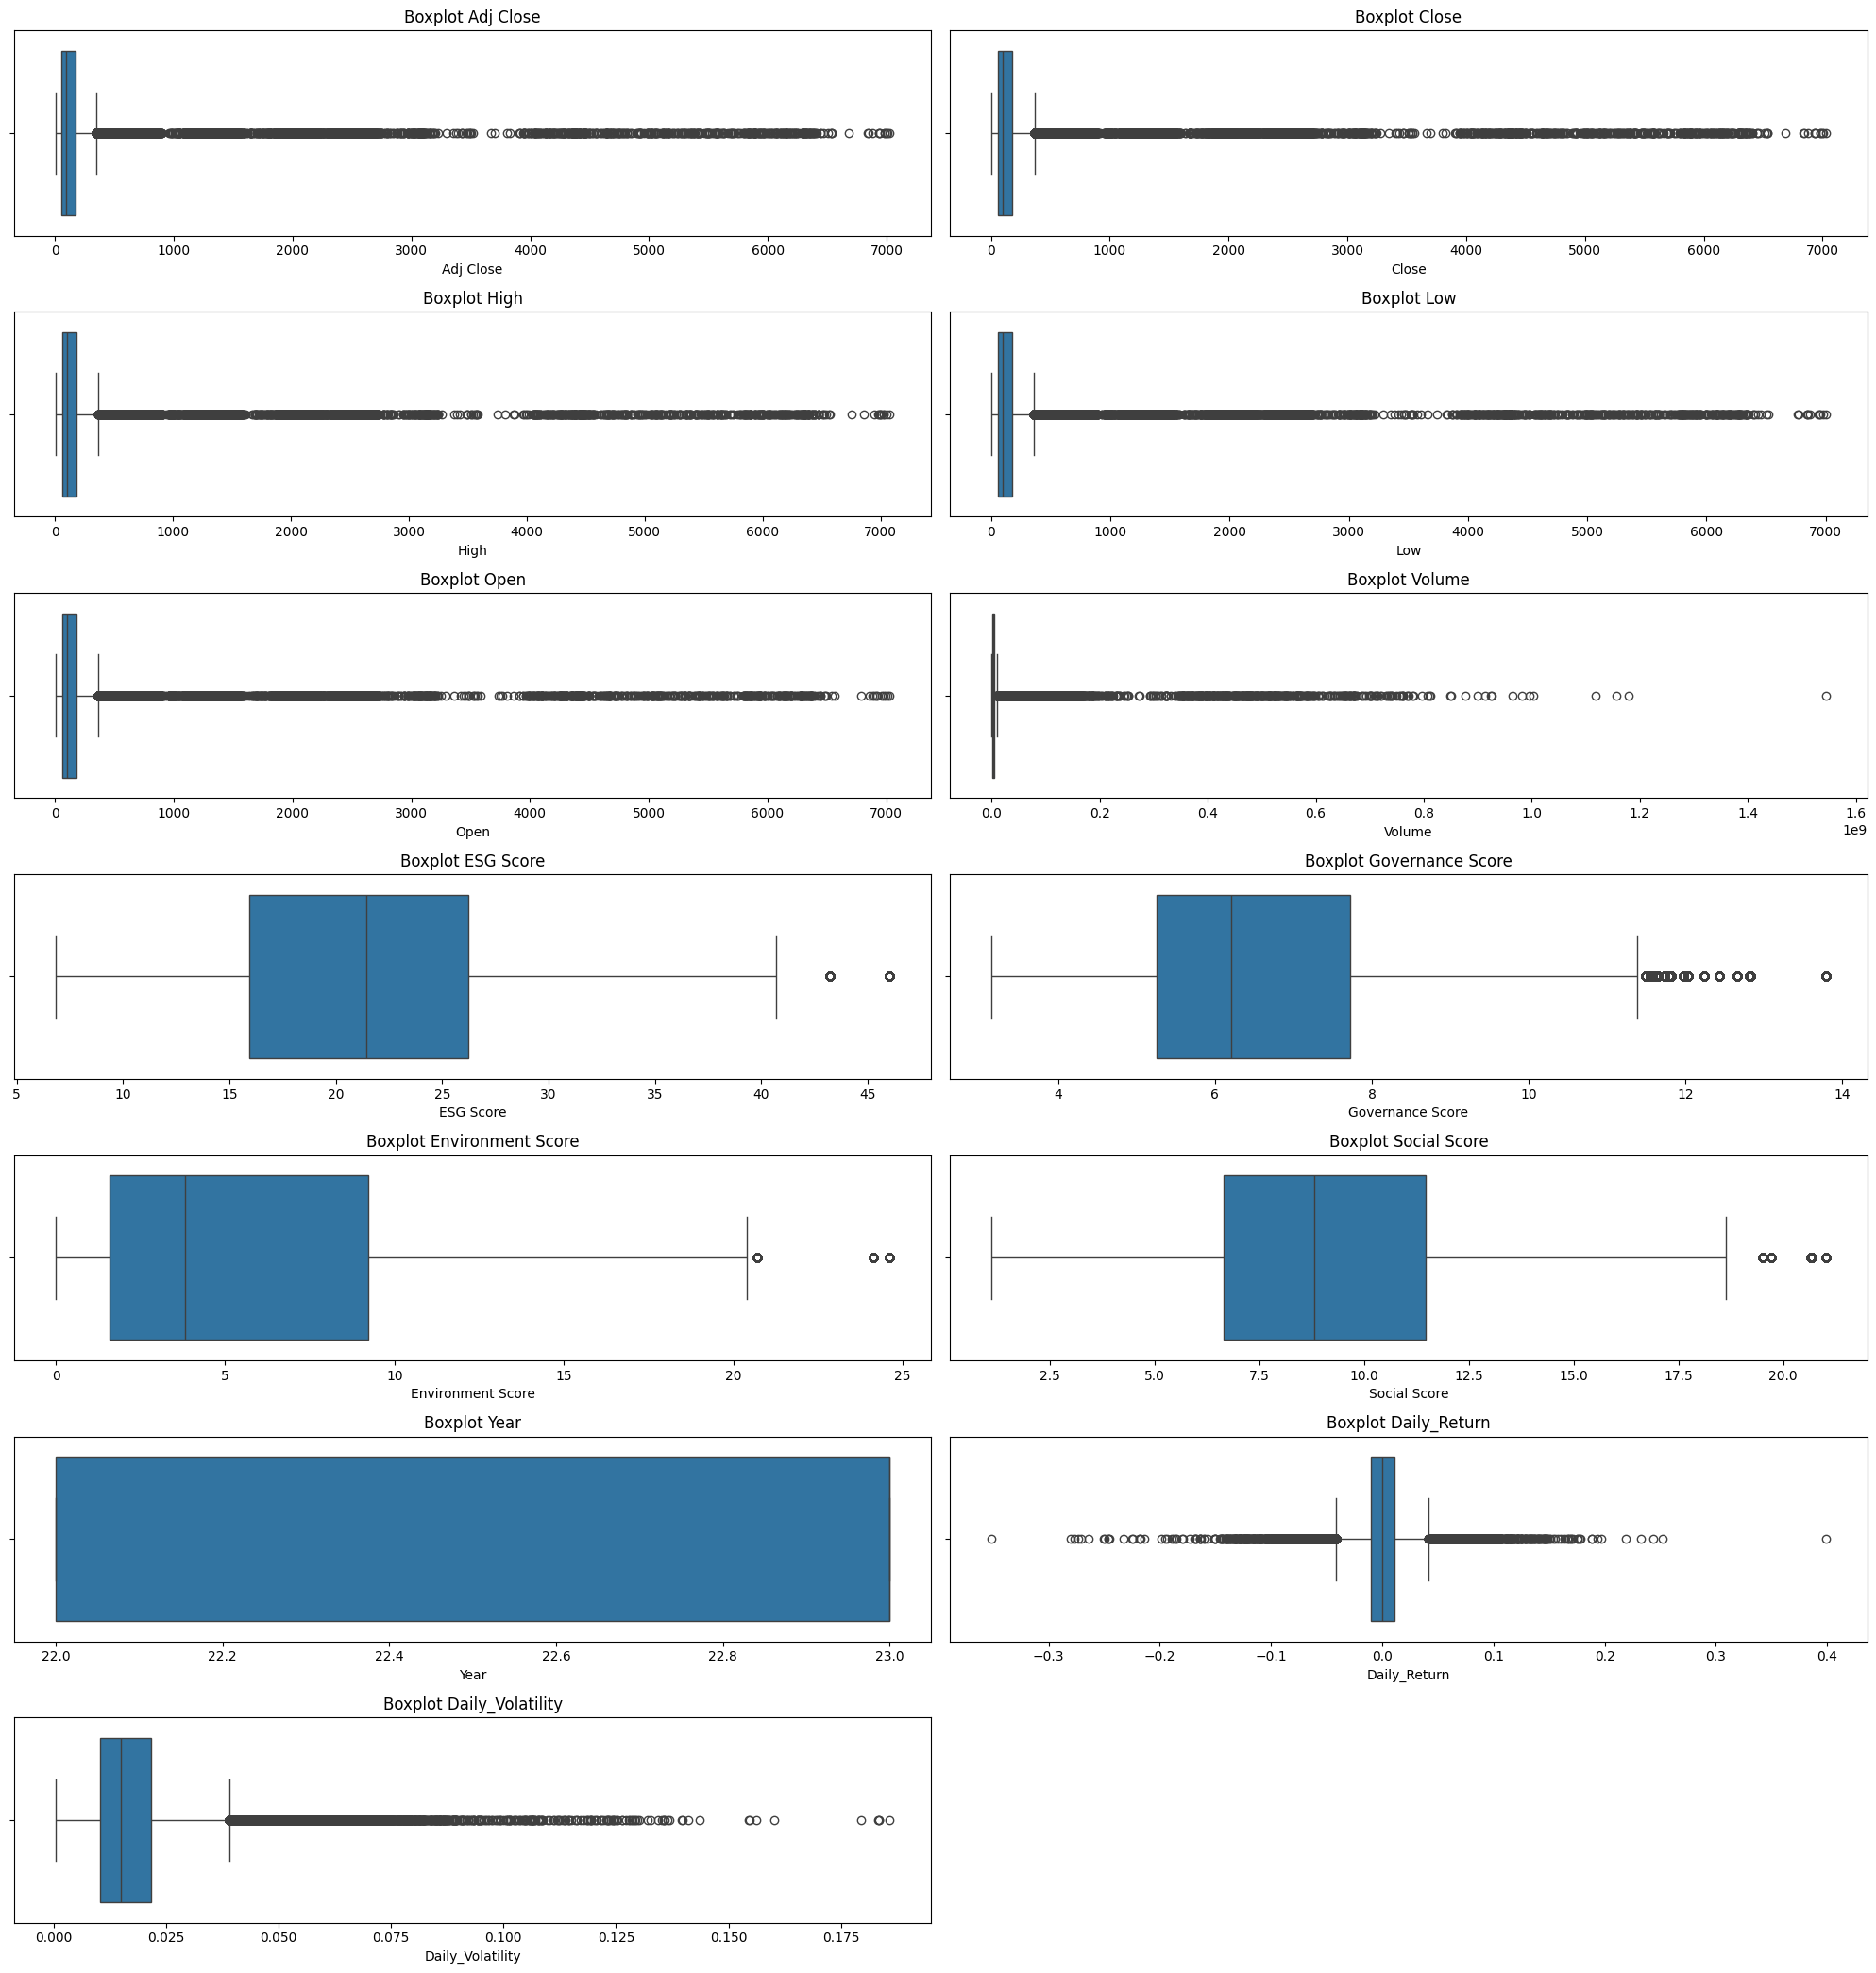

In [28]:
numerical_variables 
num_vars = len(numerical_variables)
ncols = 2
nrows = num_vars // ncols + (num_vars % ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, nrows * 3)
)

axes = axes.flatten()
for i, var in enumerate(numerical_variables):
    sns.boxplot(data=dataset_final, x=var, ax=axes[i])
    axes[i].set_title(f"Boxplot {var}")
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

**Conclusions**:

- **Prices Variables (Adj Close, Close, High, Low, Open)**: All show a very high number of outliers. This is normal in financial data, these outliers are not errors but rather represent large, genuine price swings driven by market events, news, or investor behavior.

- **Volume**: It has an extremely skewed distribution with a vast number of outliers. The box itself is very compressed at the lower end, indicating that most trading days have a relatively low volume. The outliers, which can be millions or even billions of shares, represent days with unusually high trading activity.

- **ESG Scores**: The ESG Score, Governance Score, and Social Score plots show a more contained distribution with fewer outliers. The Environment Score, however, appears to have a higher number of outliers at the upper end of the scale. This suggests that while most companies have similar environmental scores, there are a few outlier companies with exceptionally high scores. 

- **Daily Return and Daily Volatility**: Show a large number of outliers. These are not data entry errors but are genuine, high-impact data points representing days with extreme market behavior. 

- **Ticker_n, ESG ScoreDate_n, and Esg Status_n**: These are likely numerical representations of categorical variables. They simply show the spread of the numerical codes assigned to each category, which is not statistically meaningful in the same way as for continuous variables. 

### **Eliminating outliers**


In [ ]:
numerical_columns = [
   'Adj Close', 
   'Close', 
   'High', 
   'Low', 
   'Open', 
   'Volume', 
   'ESG Score',
   'Governance Score', 
   'Environment Score', 
   'Social Score', 
   'Year',
   'Daily_Return'
]

for column in numerical_columns:
    stats = dataset_final[column].describe()
    iqr = stats["75%"] - stats["25%"]
    upper_limit = stats["75%"] + 1.5 * iqr
    lower_limit = stats["25%"] - 1.5 * iqr
    if lower_limit < 0:
      lower_limit = 0
    
    outliers = dataset_final[(dataset_final[column] < lower_limit) | (dataset_final[column] > upper_limit)]
    outlier_count = outliers.shape[0]

    print(f"{column.capitalize()} — IQR: {round(iqr, 2)}, Upper limits: {round(upper_limit, 2)}, Lowerlimits: {round(lower_limit, 2)}")
    print(f"Total de outliers: {outlier_count}\n")

Adj close — IQR: 117.71, Upper limits: 349.21, Lowerlimits: 0
Total de outliers: 15471

Close — IQR: 122.99, Upper limits: 366.16, Lowerlimits: 0
Total de outliers: 14745

High — IQR: 124.36, Upper limits: 370.32, Lowerlimits: 0
Total de outliers: 14775

Low — IQR: 121.56, Upper limits: 361.85, Lowerlimits: 0
Total de outliers: 14697

Open — IQR: 122.93, Upper limits: 366.03, Lowerlimits: 0
Total de outliers: 14730

Volume — IQR: 3853825.0, Upper limits: 10706062.5, Lowerlimits: 0
Total de outliers: 20270

Esg score — IQR: 10.3, Upper limits: 41.7, Lowerlimits: 0.49
Total de outliers: 992

Governance score — IQR: 2.47, Upper limits: 11.43, Lowerlimits: 1.54
Total de outliers: 7936

Environment score — IQR: 7.62, Upper limits: 20.64, Lowerlimits: 0
Total de outliers: 1488

Social score — IQR: 4.82, Upper limits: 18.69, Lowerlimits: 0
Total de outliers: 2480

Year — IQR: 1.0, Upper limits: 24.5, Lowerlimits: 20.5
Total de outliers: 0

Daily_return — IQR: 0.02, Upper limits: 0.04, Lowerli

In [35]:
dataset_final.isnull().sum().sort_values(ascending=False) / len(dataset_final)

Date                 0.0
Ticker               0.0
Adj Close            0.0
Close                0.0
High                 0.0
Low                  0.0
Open                 0.0
Volume               0.0
ESG Score            0.0
Governance Score     0.0
Environment Score    0.0
Social Score         0.0
ESG Score Date       0.0
ESG Status           0.0
CEO Gender           0.0
Year                 0.0
Daily_Return         0.0
Daily_Volatility     0.0
Ticker_n             0.0
ESG Score Date_n     0.0
ESG Status_n         0.0
CEO Gender_n         0.0
dtype: float64

### **Split Train & Test**


In [ ]:
num_variables = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'ESG Score','Governance Score', 'Environment Score', 'Social Score', 'Year', 'Daily_Return', 'Ticker_n', 'ESG Score Date_n', 'ESG Status_n', 'CEO Gender_n']

X = dataset_final.drop("Daily_Volatility", axis = 1)[num_variables]
y = dataset_final["Daily_Volatility"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.head()

Adj Close       Close        High         Low        Open  \
49673    58.509087   63.330002   64.489998   62.799999   64.339996   
64541    80.420601   85.870003   86.529999   85.180000   86.000000   
105107   89.997681   97.599998  100.260002   97.559998  100.000000   
2286     21.193258   24.860001   25.510000   24.459999   25.430000   
23382   395.718536  404.540009  406.850006  397.579987  400.579987   

            Volume  ESG Score  Governance Score  Environment Score  \
49673    1393900.0      15.49              5.98               2.58   
64541    1063600.0      26.58              5.21              10.07   
105107    887300.0      34.09              5.27              15.25   
2286    11121300.0      16.08              7.44               1.60   
23382     339700.0      31.82              8.74              18.55   

        Social Score  Year  Daily_Return  Ticker_n  ESG Score Date_n  \
49673           6.93    23     -0.013859       281                 0   
64541          11.30    23     -0.008429       253                 0   
105107         13.57    23     -0.021554        51                 0   
2286            7.03    23     -0.010350       326                 0   
23382           4.53    23      0.018018       254                 0   

        ESG Status_n  CEO Gender_n  
49673              0             0  
64541              0             0  
105107             0             0  
2286               0             0  
23382              0             0

## **NORMALIZACION**

In [ ]:
normalizador= StandardScaler()
normalizador.fit(X_train)

X_train_norm = normalizador.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index = X_train.index, columns = num_variables)

X_test_norm = normalizador.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index = X_test.index, columns = num_variables)

X_train_norm.head()

Adj Close     Close      High       Low      Open    Volume  \
49673   -0.307581 -0.311008 -0.309726 -0.310164 -0.307948 -0.177958   
64541   -0.242019 -0.243868 -0.244865 -0.242696 -0.243421 -0.189324   
105107  -0.213363 -0.208928 -0.204459 -0.205374 -0.201713 -0.195391   
2286    -0.419236 -0.425598 -0.424439 -0.425747 -0.423866  0.156796   
23382    0.701399  0.705350  0.697796  0.699090  0.693750 -0.214236   

        ESG Score  Governance Score  Environment Score  Social Score  \
49673   -0.854793         -0.346844          -0.609089     -0.571622   
64541    0.704924         -0.706093           0.829972      0.582572   
105107   1.761143         -0.678100           1.825210      1.182119   
2286    -0.771814          0.334331          -0.797377     -0.545210   
23382    1.441887          0.940856           2.459243     -1.205504   

            Year  Daily_Return  Ticker_n  ESG Score Date_n  ESG Status_n  \
49673   0.912276     -0.695936  0.755194         -0.912276           0.0   
64541   0.912276     -0.427588  0.507870         -0.912276           0.0   
105107  0.912276     -1.076291 -1.276391         -0.912276           0.0   
2286    0.912276     -0.522536  1.152677         -0.912276           0.0   
23382   0.912276      0.879618  0.516703         -0.912276           0.0   

        CEO Gender_n  
49673      -0.308236  
64541      -0.308236  
105107     -0.308236  
2286       -0.308236  
23382      -0.308236

## **MIN MAX SCALER**

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scal = scaler.transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, index = X_train.index, columns = num_variables)

X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, index = X_test.index, columns = num_variables)

X_train_scal.head()

Adj Close     Close      High       Low      Open    Volume  \
49673    0.007445  0.008134  0.008200  0.008127  0.008273  0.000899   
64541    0.010574  0.011353  0.011330  0.011336  0.011366  0.000685   
105107   0.011942  0.013028  0.013280  0.013111  0.013366  0.000571   
2286     0.002116  0.002639  0.002665  0.002631  0.002715  0.007199   
23382    0.055605  0.056865  0.056816  0.056123  0.056298  0.000216   

        ESG Score  Governance Score  Environment Score  Social Score  Year  \
49673    0.220776          0.265977           0.104835      0.292462   1.0   
64541    0.503828          0.193609           0.409183      0.512060   1.0   
105107   0.695508          0.199248           0.619667      0.626131   1.0   
2286     0.235835          0.403195           0.065014      0.297487   1.0   
23382    0.637570          0.525376           0.753759      0.171859   1.0   

        Daily_Return  Ticker_n  ESG Score Date_n  ESG Status_n  CEO Gender_n  
49673       0.449942  0.718670               0.0           0.0           0.0  
64541       0.457184  0.647059               0.0           0.0           0.0  
105107      0.439677  0.130435               0.0           0.0           0.0  
2286        0.454621  0.833760               0.0           0.0           0.0  
23382       0.492462  0.649616               0.0           0.0           0.0

In [ ]:
# Columnas
fin_columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Year', 'Daily_Return', 'Ticker_n']
esg_columns = ['ESG Score', 'Governance Score', 'Environment Score', 'Social Score', 
               'ESG Score Date_n', 'ESG Status_n', 'CEO Gender_n', 'Ticker_n']

# Escalar cada grupo
scaler_fin = StandardScaler()
X_fin_scaled = scaler_fin.fit_transform(X_train[fin_columns])
X_fin_scaled_test = scaler_fin.transform(X_test[fin_columns])

scaler_esg = StandardScaler()
X_esg_scaled = scaler_esg.fit_transform(X_train[esg_columns])
X_esg_scaled_test = scaler_esg.transform(X_test[esg_columns])

# Concatenar
X_train_mix = np.hstack([X_fin_scaled, X_esg_scaled])
X_test_mix = np.hstack([X_fin_scaled_test, X_esg_scaled_test])


In [ ]:
dataframes = {
    "X_train": X_train,
    "X_train_norm": X_train_norm,
    "X_train_scal": X_train_scal,
    "X_test": X_test,
    "X_test_norm": X_test_norm,
    "X_test_scal": X_test_scal,
    "y_train": y_train,
    "y_test": y_test,
    "X_train_mix": X_train_mix,
    "X_test_mix": X_test_mix,
}

save_path = "../data/processed/"

for name, df in dataframes.items():
    # Si es numpy array, convertir a DataFrame
    if isinstance(df, np.ndarray):
        # Intentamos poner nombres de columnas si existen
        if "mix" in name:
            # Para X_train_mix / X_test_mix
            fin_columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Year', 'Daily_Return', 'Ticker_n']
            esg_columns = ['ESG Score', 'Governance Score', 'Environment Score', 'Social Score', 
                           'ESG Score Date_n', 'ESG Status_n', 'CEO Gender_n', 'Ticker_n']
            columns = fin_columns + esg_columns
        else:
            # Para escalado estándar sin nombres
            columns = [f"col_{i}" for i in range(df.shape[1])]
        df = pd.DataFrame(df, columns=columns)
    
    df.to_csv(f"{save_path}{name}.csv", index=False)


In [41]:
# Save the scaler and normalizer models
models = {
    "normalizer": normalizador,
    "scaler": scaler,
     
} 

save_path = "../models/"

for name, df in models.items():
    with open(f"{save_path}{name}.pkl", "wb") as file:
        pickle.dump(df, file)

---------------------------------------------


## **MACHINE LEARNING**

### **LINEAR REGRESSION**

In [ ]:
r2_results = []
mse_results = []

for dataset in [
    X_train,
    X_train_norm,
    X_train_scal,
    X_train_mix,
]:
    LR_model = LinearRegression()
    LR_model.fit(dataset, y_train)
    y_pred = LR_model.predict(dataset)
    
    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    
    r2_results.append(r2)
    mse_results.append(mse)

print("R2 scores:", r2_results)
print("Best R2:", max(r2_results))
print("MSE:", mse_results)
print("Best MSE:", min(mse_results))

R2 scores: [0.09431782995925575, 0.09431782995925642, 0.09431782995925564, 0.09431782995925597]
Best R2: 0.09431782995925642
MSE: [0.00010072391083549872, 0.00010072391083549864, 0.00010072391083549872, 0.00010072391083549869]
Best MSE: 0.00010072391083549864


In [ ]:
LR_model = LinearRegression()
LR_model.fit(X_train_mix, y_train)

y_pred_test = LR_model.predict(X_test_mix)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"The R2 on the test set of the linear regression model is {r2_test} and the MSE on the test set is {mse_test}")

El R2 en test del modelo de regresión lineal es de 0.09168602098337175 y el MSE en test es 0.00010063283594002768


In [ ]:

with open("linear_regression_model.pkl", "wb") as f:
    pickle.dump(LR_model, f)

##  **RANDOM FOREST**

In [ ]:
r2_results = []
mse_results = []

for dataset in [
    X_train,
    X_train_norm,
    X_train_scal,
    X_train_mix,
]:
    model = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
    
    model = RandomForestRegressor()
    model.fit(dataset, y_train)
    y_pred = model.predict(dataset)

    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    
    r2_results.append(r2)
    mse_results.append(mse)

print("R2 scores:", r2_results)
print("Best R2:", max(r2_results))
print("MSE:", mse_results)
print("Best MSE:", min(mse_results))

R2 scores: [0.9156624895501286, 0.915596224139982, 0.9155436180832506, 0.9156235714651744]
Best R2: 0.9156624895501286
MSE: [9.379453591604464e-06, 9.386823187124698e-06, 9.3926736807558e-06, 9.383781800603707e-06]
Best MSE: 9.379453591604464e-06


In [ ]:
model = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_mix, y_train)
y_pred_test = model.predict(X_test_mix)

y_pred_test = model.predict(X_test_mix)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"The R2 on the test set of the random forest model is {r2_test} and the MSE on the test set is {mse_test}")

El R2 en test del modelo de random forest es de 0.3564890160710097 y el MSE en test es 7.129509923588477e-05


In [ ]:
# Modelo base
.#model = RandomForestRegressor(
    #n_estimators=400,
    #max_depth=10,
    #min_samples_split=5,
    #min_samples_leaf=2,
    #max_features="sqrt",
    #random_state=42,
    #n_jobs=-1
)

# Grid de hiperparámetros
#param_grid = {
    #'n_estimators': [200, 400, 600],
    #'max_depth': [None, 10, 20],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],
    #'max_features': ['sqrt', 'log2']
}

# TimeSeriesSplit para respetar dependencia temporal
#tscv = TimeSeriesSplit(n_splits=5)

# RandomizedSearchCV (más rápido que GridSearch)
#random_search = RandomizedSearchCV(
    #estimator=model,
    #param_distributions=param_grid,
    #n_iter=20,            # número de combinaciones a probar
    #cv=tscv,
    #scoring='r2',         # R2 como métrica principal
    #verbose=2,
    #n_jobs=-1,
    #random_state=42
)

# Entrenamiento
#random_search.fit(X_train_norm, y_train)

# Mejor modelo
#best_model = random_search.best_estimator_
#y_pred = best_model.predict(X_test_norm)

# Evaluación
#r2 = r2_score(y_test, y_pred)

# si tu scikit-learn es viejo, hazlo así:
#mse = mean_squared_error(y_test, y_pred)
#rmse = np.sqrt(mse)

#print("Best parameters:", random_search.best_params_)
#print("R2 on test set:", r2)
#print("RMSE on test set:", rmse)

SyntaxError: unmatched ')' (1035877710.py, line 15)

In [ ]:
with open("timeseries_randomizedsearch_RF_model.pkl", "wb") as f:
    #pickle.dump(best_model, f)

KeyboardInterrupt: 

## **XGBOOST** 

In [ ]:

X_train_clean = np.nan_to_num(X_train_mix).astype(np.float32)
X_test_clean = np.nan_to_num(X_test_mix).astype(np.float32)
y_train_clean = np.nan_to_num(y_train).astype(np.float32)
y_test_clean = np.nan_to_num(y_test).astype(np.float32)

XGBoost_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "n_estimators": [400, 500, 600],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.03, 0.05, 0.07],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "min_child_weight": [3, 5, 7],
    "gamma": [0, 0.1, 0.2],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 1.5, 2]
}

tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(
    estimator=XGBoost_model,
    param_distributions=param_grid,
    n_iter=25,               
    cv=tscv,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_clean, y_train_clean)

XGBoost_model = random_search.best_estimator_
y_pred_test = XGBoost_model.predict(X_test_clean)

r2_test = r2_score(y_test_clean, y_pred_test)
mse_test = mean_squared_error(y_test_clean, y_pred_test)
rmse_test = np.sqrt(mse_test)

print("Best parameters:", random_search.best_params_)
print("R² test:", r2_test)
print("RMSE test:", rmse_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 600, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.07, 'gamma': 0, 'colsample_bytree': 0.8}
R² test: 0.43283218145370483
RMSE test: 0.00792697763296809


In [ ]:

with open("XGBoost_model.pkl", "wb") as f:
    pickle.dump(XGBoost_model, f)

##  **K MEANS** 

In [52]:
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_mix)
X_test_pca = pca.transform(X_test_mix)

print("Variance explained per component:", pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))

Variance explained per component: [0.31428432 0.14253746 0.12931197 0.1203333  0.07636914]
Total variance explained: 0.7828361907322398


In [53]:
kmeans_model = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters_train = kmeans_model.fit_predict(X_train_pca)
clusters_test = kmeans_model.predict(X_test_pca)

In [54]:
X_train['cluster'] = clusters_train
X_test['cluster'] = clusters_test

In [ ]:
num_variables = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]

X_train_knn_df = pd.DataFrame(X_train_pca, columns=num_variables)
X_test_knn_df = pd.DataFrame(X_test_pca, columns=num_variables)

y_train = X_train['cluster']
y_test = X_test['cluster']

## **KNN**

In [ ]:

knn_model = KNeighborsRegressor(
    n_neighbors=5,
    metric='euclidean',
    weights='distance'
)

knn_model.fit(X_train_knn_df, y_train)

y_pred_train = knn_model.predict(X_train_knn_df)
y_pred_test = knn_model.predict(X_test_knn_df)

r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)

r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

print("🔹 Train metrics:")
print(f"R²:   {r2_train:.2f}")
print(f"MSE:  {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")

print("\n🔹 Test metrics:")
print(f"R²:   {r2_test:.2f}")
print(f"MSE:  {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")

🔹 Train metrics:
R²:   1.00
MSE:  0.00
RMSE: 0.00

🔹 Test metrics:
R²:   1.00
MSE:  0.01
RMSE: 0.08


## **Performance Comparison of XGB, KNN, LGBM, CatBoost, and Stacking**

In [ ]:

def evaluate(model, X_train, X_test, y_train, y_test, model_name="model"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return {"model": model_name, "rmse": rmse, "mae": mae, "r2": r2}

# Base models
lgb_model = lgb.LGBMRegressor(objective="regression", random_state=42)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
cat_model = CatBoostRegressor(loss_function="RMSE", verbose=0, random_state=42)
knn_model = KNeighborsRegressor(
    n_neighbors=5,
    metric="euclidean",
    weights="distance"
)

# Stacking model with Ridge
stack_model = StackingRegressor(
    estimators=[
        ("lgb", lgb_model),
        ("xgb", xgb_model),
        ("cat", cat_model),
        ("knn", knn_model),  
    ],
    final_estimator=Ridge(),
    passthrough=False
)

# Datasets to evaluate
datasets = {
    "raw": (X_train, X_test),
    "norm": (X_train_norm, X_test_norm),
    "scal": (X_train_scal, X_test_scal),
    "mix": (X_train_mix, X_test_mix),
}

results = []

for name, (Xtr, Xte) in datasets.items():
    print(f"\n=== Dataset: {name} ===")
    results.append(evaluate(lgb_model, Xtr, Xte, y_train, y_test, f"LGBM ({name})"))
    results.append(evaluate(xgb_model, Xtr, Xte, y_train, y_test, f"XGB ({name})"))
    results.append(evaluate(cat_model, Xtr, Xte, y_train, y_test, f"CatBoost ({name})"))
    results.append(evaluate(knn_model, Xtr, Xte, y_train, y_test, f"KNN ({name})"))  
    results.append(evaluate(stack_model, Xtr, Xte, y_train, y_test, f"Stacking ({name})"))
    

# Collect results
df_results = pd.DataFrame(results)
df_results.sort_values(by="r2", ascending=False)





=== Dataset: raw ===
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3055
[LightGBM] [Info] Number of data points in the train set: 155545, number of used features: 16
[LightGBM] [Info] Start training from score 3.105776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3309
[LightGBM] [Info] Number of data points in the train set: 155545, number of used features: 16
[LightGBM] [Info] Start training from score 3.105776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3304
[LightGBM] [Info] Number of data points in the train set: 124436, number of used features: 16
[LightGBM] [Info] Start training from score 3.103716


C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3306
[LightGBM] [Info] Number of data points in the train set: 124436, number of used features: 16
[LightGBM] [Info] Start training from score 3.109157


C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3306
[LightGBM] [Info] Number of data points in the train set: 124436, number of used features: 16
[LightGBM] [Info] Start training from score 3.103708


C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3304
[LightGBM] [Info] Number of data points in the train set: 124436, number of used features: 16
[LightGBM] [Info] Start training from score 3.105990


C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3307
[LightGBM] [Info] Number of data points in the train set: 124436, number of used features: 16
[LightGBM] [Info] Start training from score 3.106312


C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


model      rmse       mae        r2
1         XGB (raw)  0.000003  0.000002  1.000000
0        LGBM (raw)  0.000058  0.000051  1.000000
4    Stacking (raw)  0.000219  0.000085  1.000000
2    CatBoost (raw)  0.000689  0.000268  1.000000
14  Stacking (scal)  0.055636  0.001591  0.999353
13       KNN (scal)  0.056130  0.000977  0.999341
5       LGBM (norm)  0.057558  0.004893  0.999307
15       LGBM (mix)  0.057558  0.004893  0.999307
19   Stacking (mix)  0.058094  0.004524  0.999294
10      LGBM (scal)  0.058798  0.004469  0.999277
9   Stacking (norm)  0.058864  0.004705  0.999276
7   CatBoost (norm)  0.064811  0.008868  0.999122
12  CatBoost (scal)  0.065285  0.009287  0.999109
17   CatBoost (mix)  0.065650  0.008956  0.999099
18        KNN (mix)  0.074544  0.002653  0.998838
11       XGB (scal)  0.076598  0.005908  0.998773
16        XGB (mix)  0.076802  0.005947  0.998767
6        XGB (norm)  0.076802  0.005949  0.998767
8        KNN (norm)  0.080349  0.003187  0.998650
3         KNN (raw)  2.216412  1.790016 -0.027060

## **LGBM**

In [60]:
results_test = []

for name, (Xtr, Xte) in datasets.items():
    print(f"\n=== Dataset: {name} ===")
    
    # LGBM
    lgb_model.fit(Xtr, y_train)
    y_pred_test = lgb_model.predict(Xte)
    results_test.append({
        "model": f"LGBM ({name})",
        "r2_test": r2_score(y_test, y_pred_test),
        "mse_test": mean_squared_error(y_test, y_pred_test),
        "rmse_test": np.sqrt(mean_squared_error(y_test, y_pred_test))
    })
    
    # XGB
    xgb_model.fit(Xtr, y_train)
    y_pred_test = xgb_model.predict(Xte)
    results_test.append({
        "model": f"XGB ({name})",
        "r2_test": r2_score(y_test, y_pred_test),
        "mse_test": mean_squared_error(y_test, y_pred_test),
        "rmse_test": np.sqrt(mean_squared_error(y_test, y_pred_test))
    })
    
    # CatBoost
    cat_model.fit(Xtr, y_train)
    y_pred_test = cat_model.predict(Xte)
    results_test.append({
        "model": f"CatBoost ({name})",
        "r2_test": r2_score(y_test, y_pred_test),
        "mse_test": mean_squared_error(y_test, y_pred_test),
        "rmse_test": np.sqrt(mean_squared_error(y_test, y_pred_test))
    })
    
    # KNN
    knn_model.fit(Xtr, y_train)
    y_pred_test = knn_model.predict(Xte)
    results_test.append({
        "model": f"KNN ({name})",
        "r2_test": r2_score(y_test, y_pred_test),
        "mse_test": mean_squared_error(y_test, y_pred_test),
        "rmse_test": np.sqrt(mean_squared_error(y_test, y_pred_test))
    })
    
    # Stacking
    stack_model.fit(Xtr, y_train)
    y_pred_test = stack_model.predict(Xte)
    results_test.append({
        "model": f"Stacking ({name})",
        "r2_test": r2_score(y_test, y_pred_test),
        "mse_test": mean_squared_error(y_test, y_pred_test),
        "rmse_test": np.sqrt(mean_squared_error(y_test, y_pred_test))
    })

# Convert results to DataFrame
df_results_test = pd.DataFrame(results_test).sort_values(by="r2_test", ascending=False).reset_index(drop=True)
print(df_results_test)



=== Dataset: raw ===
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3055
[LightGBM] [Info] Number of data points in the train set: 155545, number of used features: 16
[LightGBM] [Info] Start training from score 3.105776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3309
[LightGBM] [Info] Number of data points in the train set: 155545, number of used features: 16
[LightGBM] [Info] Start training from score 3.105776
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3304
[LightGBM] [Info] Number of data points in the train set: 124436, number of used features: 16
[LightGBM] [Info] Start training from score 3.103716


C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3306
[LightGBM] [Info] Number of data points in the train set: 124436, number of used features: 16
[LightGBM] [Info] Start training from score 3.109157


C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3306
[LightGBM] [Info] Number of data points in the train set: 124436, number of used features: 16
[LightGBM] [Info] Start training from score 3.103708


C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3304
[LightGBM] [Info] Number of data points in the train set: 124436, number of used features: 16
[LightGBM] [Info] Start training from score 3.105990


C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3307
[LightGBM] [Info] Number of data points in the train set: 124436, number of used features: 16
[LightGBM] [Info] Start training from score 3.106312


C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


              model   r2_test      mse_test  rmse_test
0         XGB (raw)  1.000000  7.350461e-12   0.000003
1        LGBM (raw)  1.000000  3.374482e-09   0.000058
2    Stacking (raw)  1.000000  4.807093e-08   0.000219
3    CatBoost (raw)  1.000000  4.744742e-07   0.000689
4   Stacking (scal)  0.999353  3.095384e-03   0.055636
5        KNN (scal)  0.999341  3.150612e-03   0.056130
6       LGBM (norm)  0.999307  3.312897e-03   0.057558
7        LGBM (mix)  0.999307  3.312911e-03   0.057558
8    Stacking (mix)  0.999294  3.374956e-03   0.058094
9       LGBM (scal)  0.999277  3.457177e-03   0.058798
10  Stacking (norm)  0.999276  3.464969e-03   0.058864
11  CatBoost (norm)  0.999122  4.200402e-03   0.064811
12  CatBoost (scal)  0.999109  4.262125e-03   0.065285
13   CatBoost (mix)  0.999099  4.309922e-03   0.065650
14        KNN (mix)  0.998838  5.556803e-03   0.074544
15       XGB (scal)  0.998773  5.867249e-03   0.076598
16        XGB (mix)  0.998767  5.898491e-03   0.076802
17       X

### **Saving the LGBM (mix) Model**

In [ ]:

lgb_model = lgb.LGBMRegressor(objective="regression", random_state=42)
lgb_model.fit(X_train_mix, y_train)

y_pred_train = lgb_model.predict(X_train_mix)
y_pred_test = lgb_model.predict(X_test_mix)

with open("lgbm_mix_model.pkl", "wb") as f:
    pickle.dump(lgb_model, f)

print("Model saved as lgbm_mix_model.pkl")


df_train = pd.DataFrame({
    "y_true": y_train,
    "y_pred": y_pred_train,
    "dataset": "train"
})

df_test = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_test,
    "dataset": "test"
})

df_results = pd.concat([df_train, df_test], ignore_index=True)
df_results.to_csv("lgbm_mix_model_train_test_results.csv", index=False)
print("Predictions  as train_test_results.csv")


metrics = {
    "MSE_train": mean_squared_error(y_train, y_pred_train),
    "RMSE_train": np.sqrt(mean_squared_error(y_train, y_pred_train)),
    "MAE_train": mean_absolute_error(y_train, y_pred_train),
    "R2_train": r2_score(y_train, y_pred_train),

    "MSE_test": mean_squared_error(y_test, y_pred_test),
    "RMSE_test": np.sqrt(mean_squared_error(y_test, y_pred_test)),
    "MAE_test": mean_absolute_error(y_test, y_pred_test),
    "R2_test": r2_score(y_test, y_pred_test),
}

with open("lgbm_mix_model_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("Metrics saved as metrics.json")




[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3309
[LightGBM] [Info] Number of data points in the train set: 155545, number of used features: 16
[LightGBM] [Info] Start training from score 3.105776


C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Model saved as lgbm_mix_model.pkl
Predictions  as train_test_results.csv
Metrics saved as metrics.json


-----------------------------------------

## **STREAMLIT**

In [ ]:

# =====================
# Load model & metrics
# =====================
@st.cache_resource
def load_model():
    with open("lgbm_mix_model.pkl", "rb") as f:
        model = pickle.load(f)
    return model

@st.cache_data
def load_metrics():
    with open("metrics.json", "r") as f:
        metrics = json.load(f)
    return metrics

model = load_model()
metrics = load_metrics()

# =====================
# Load full processed dataset
# =====================
@st.cache_data
def load_full_dataset():
    df = pd.read_csv("data/processed/dataset_final.csv")
    df = df.set_index("Ticker")
    return df

# =====================
# Helper functions
# =====================
def fetch_price_data(ticker, period="1y"):
    df = yf.download(ticker, period=period)
    df["Return"] = df["Close"].pct_change()
    df["Volatility"] = df["Return"].rolling(window=21).std() * np.sqrt(252)
    return df

def prepare_features(ticker):
    df = load_full_dataset()
    if ticker not in df.index:
        raise ValueError(f"Ticker {ticker} not found in processed dataset")

    row = df.loc[ticker].copy()
    
    features = pd.DataFrame([row])
    return features

# =====================
# Streamlit UI
# =====================
st.set_page_config(page_title="ESG & Market Volatility", layout="wide")
st.title("ESG & Market Volatility Dashboard")

st.sidebar.header("Trained Model Metrics")
st.sidebar.json(metrics)

st.header("Volatility Prediction")
ticker = st.text_input("Enter a ticker (e.g. AAPL, MSFT, TSLA):", "AAPL")
period = st.selectbox("Historical period", ["1y", "6mo", "3mo", "1mo"], index=0)

if st.button("Predict"):
    try:
        df_price = fetch_price_data(ticker, period)
        st.subheader(f"Price history for {ticker}")
        st.line_chart(df_price["Close"])
        st.subheader("Historical volatility (21-day rolling, annualized)")
        st.line_chart(df_price["Volatility"])

        X_new = prepare_features(ticker)
        pred_vol = model.predict(X_new)[0]
        st.success(f"Predicted volatility for {ticker}: **{pred_vol:.4f}**")

    except Exception as e:
        st.error(f"Error processing ticker {ticker}: {e}")

st.header("Training & Test Predictions")
df_results = pd.read_csv("train_test_results.csv")
st.dataframe(df_results.head(20))


2025-09-26 16:38:47.242 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-26 16:38:47.245 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 16:38:47.779 
  command:

    streamlit run C:\Users\34722\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-26 16:38:47.779 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 16:38:47.779 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 16:38:47.779 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-26 16:38:47.798 Thread 'MainThread': missing ScriptRunContext! This war

DeltaGenerator()